In [1]:
from pathlib import Path
from skimage.filters import threshold_otsu
from scipy import stats
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA


import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ROOT = Path.home() / "Documents/project_004/data/data_small_zfish"
files = sorted(p for p in ROOT.glob("*.[tif][iI][fF]*"))
len(files), files

(6,
 [PosixPath('/home/pxbloe/Documents/project_004/data/data_small_zfish/Control1.tif'),
  PosixPath('/home/pxbloe/Documents/project_004/data/data_small_zfish/Control2.tif'),
  PosixPath('/home/pxbloe/Documents/project_004/data/data_small_zfish/Mutant1.tif'),
  PosixPath('/home/pxbloe/Documents/project_004/data/data_small_zfish/Mutant2.tif'),
  PosixPath('/home/pxbloe/Documents/project_004/data/data_small_zfish/Mutant3.tif'),
  PosixPath('/home/pxbloe/Documents/project_004/data/data_small_zfish/Mutant4.tif')])

In [35]:
# read each stack; ensure shape is (T,H,W); normalize per frame to [0,1]
stacks = [tiff.imread(str(f)) for f in files]
norm = lambda s: (s - np.min(s, axis=(1,2), keepdims=True)) / (np.ptp(s, axis=(1,2), keepdims=True) + 1e-8)
stacks = [norm(s.astype(np.float32)) for s in stacks]

# concatenate all frames from all stacks
images = np.concatenate(stacks, axis=0)
images.shape

(2700, 200, 200)

In [36]:
EPS = 1e-6
masks = (images > EPS).astype(np.uint8)
print("masks shape:", masks.shape, "dtype:", masks.dtype)

masks shape: (2700, 200, 200) dtype: uint8


In [39]:
# compute Otsu threshold per frame, then binarize
thr = np.array([threshold_otsu(fr) for fr in images], dtype=np.float32)
masks = (images >= thr[:, None, None]).astype(np.uint8)

print("masks shape:", masks.shape, "dtype:", masks.dtype)

masks shape: (2700, 200, 200) dtype: uint8


In [40]:
embryo_ids = [Path(str(p)).stem for p in files]
lengths = [s.shape[0] for s in stacks]

dfmeta = pd.DataFrame({
    "embryo_id": np.concatenate([[eid]*L for eid, L in zip(embryo_ids, lengths)]),
    "frame_idx": np.concatenate([np.arange(L) for L in lengths]),
})
print(dfmeta.shape)
dfmeta.head()

(2700, 2)


embryo_id  frame_idx
0  Control1          0
1  Control1          1
2  Control1          2
3  Control1          3
4  Control1          4

In [41]:
N = images.shape[0]
flat_masked = np.where(masks.reshape(N, -1)>0, images.reshape(N, -1), np.nan)

i_min  = np.nanmin(flat_masked, axis=1)
i_max  = np.nanmax(flat_masked, axis=1)
i_mean = np.nanmean(flat_masked, axis=1)
i_std  = np.nanstd(flat_masked, axis=1)
# skew and kurtosis requires NaN:
vals = [row[~np.isnan(row)] for row in flat_masked]
i_skew = np.array([stats.skew(v, bias=False) if v.size>2 else np.nan for v in vals])
i_kurt = np.array([stats.kurtosis(v, bias=False) if v.size>3 else np.nan for v in vals])

area_mask = masks.reshape(N, -1).sum(axis=1).astype(float)

feats_A = pd.DataFrame({
    "i_min": i_min, "i_max": i_max, "i_mean": i_mean, "i_std": i_std,
    "i_skew": i_skew, "i_kurt": i_kurt, "area_mask": area_mask
})
feats_A.describe().T


count         mean          std          min          25%  \
i_min      2700.0     0.342400     0.039870     0.000000     0.312195   
i_max      2700.0     0.999259     0.027212     0.000000     1.000000   
i_mean     2700.0     0.672746     0.079726     0.000000     0.611763   
i_std      2700.0     0.160953     0.019503     0.000000     0.149723   
i_skew     2698.0    -0.248475     0.409381    -1.499208    -0.570615   
i_kurt     2698.0    -0.741623     0.531662    -1.585157    -1.053821   
area_mask  2700.0  8680.675185  1388.722236  5534.000000  8148.000000   

                   50%          75%           max  
i_min         0.345929     0.376985      0.417143  
i_max         1.000000     1.000000      1.000000  
i_mean        0.681089     0.740416      0.810801  
i_std         0.161064     0.174162      0.211718  
i_skew       -0.281173     0.057784      0.913140  
i_kurt       -0.849741    -0.554974      3.651349  
area_mask  8798.000000  9362.250000  40000.000000

In [7]:
areas, perims, eccs, solids, extents, maj_ax, min_ax, aratios, compact = [],[],[],[],[],[],[],[],[]

for m in masks:
    lab = label(m, connectivity=2)
    if lab.max() == 0:
        areas.append(np.nan); perims.append(np.nan); eccs.append(np.nan)
        solids.append(np.nan); extents.append(np.nan)
        maj_ax.append(np.nan); min_ax.append(np.nan)
        aratios.append(np.nan); compact.append(np.nan)
        continue
    props = sorted(regionprops(lab), key=lambda p: p.area, reverse=True)[0]
    A = float(props.area)
    P = float(props.perimeter) if props.perimeter not in (None, 0) else np.nan
    MAJ = float(props.major_axis_length) if props.major_axis_length else np.nan
    MIN = float(props.minor_axis_length) if props.minor_axis_length else np.nan
    AR  = (MAJ/MIN) if (MAJ and MIN and MIN>0) else np.nan
    C   = (4*np.pi*A/(P**2)) if (P and P>0) else np.nan

    areas.append(A); perims.append(P); eccs.append(float(props.eccentricity))
    solids.append(float(props.solidity)); extents.append(float(props.extent))
    maj_ax.append(MAJ); min_ax.append(MIN); aratios.append(AR); compact.append(C)

feats_B = pd.DataFrame({
    "shape_area": areas, "shape_perimeter": perims, "shape_eccentricity": eccs,
    "shape_solidity": solids, "shape_extent": extents,
    "shape_major_axis": maj_ax, "shape_minor_axis": min_ax,
    "shape_aspect_ratio": aratios, "shape_compactness": compact
})
feats_B.describe().T

count          mean          std          min  \
shape_area          2698.0  10304.839140  1150.829039  7703.000000   
shape_perimeter     2698.0    401.505951    33.456559   339.433550   
shape_eccentricity  2698.0      0.415672     0.211166     0.038410   
shape_solidity      2698.0      0.979288     0.007972     0.935422   
shape_extent        2698.0      0.747686     0.042428     0.579691   
shape_major_axis    2698.0    124.256905    17.629607    99.998474   
shape_minor_axis    2698.0    106.678569     6.407750    87.335693   
shape_aspect_ratio  2698.0      1.174483     0.228725     1.000738   
shape_compactness   2698.0      0.805331     0.050966     0.599122   

                            25%           50%           75%           max  
shape_area          9663.250000  10291.500000  11023.750000  13202.000000  
shape_perimeter      379.989899    394.818326    418.207413    499.972655  
shape_eccentricity     0.239249      0.387082      0.567580      0.872433  
shape_solidity         0.975925      0.982735      0.984654      0.988291  
shape_extent           0.728511      0.763179      0.776315      0.830640  
shape_major_axis     113.761001    118.062246    130.280959    185.881978  
shape_minor_axis     102.270369    108.309901    111.680343    119.411592  
shape_aspect_ratio     1.029910      1.084546      1.214597      2.046105  
shape_compactness      0.784507      0.819500      0.838293      0.895611

In [38]:
# a 8 bits para GLCM
imgs8 = (images*255).astype(np.uint8) 
#Masking again
imgs8_masked = np.where(masks>0, imgs8, 0).astype(np.uint8) 

contr, corr, homog, energy, asm_vals, entropy = [],[],[],[],[],[] 

for x in imgs8_masked:    
    glcm = graycomatrix(x, distances=[1,2], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    contr.append(float(graycoprops(glcm, 'contrast').mean()))
    corr.append(float(graycoprops(glcm, 'correlation').mean()))
    homog.append(float(graycoprops(glcm, 'homogeneity').mean()))
    energy.append(float(graycoprops(glcm, 'energy').mean()))
    asm_vals.append(float(graycoprops(glcm, 'ASM').mean()))
    P = glcm / (glcm.sum() + 1e-12)
    entropy.append(float(-np.sum(P * np.log(P + 1e-12))))

feats_C = pd.DataFrame({"glcm_contrast": contr, "glcm_corr": corr, "glcm_homog": homog,"glcm_energy": energy, 
                        "glcm_ASM": asm_vals, "glcm_entropy": entropy})
feats_C.describe().T

count        mean        std       min         25%  \
glcm_contrast  2700.0  145.309056  42.411290  0.000000  113.373046   
glcm_corr      2700.0    0.986277   0.003513  0.966379    0.983964   
glcm_homog     2700.0    0.779762   0.027765  0.703433    0.764668   
glcm_energy    2700.0    0.735894   0.030234  0.661570    0.717330   
glcm_ASM       2700.0    0.542456   0.044849  0.437679    0.514564   
glcm_entropy   2700.0    4.787144   0.321425  2.079442    4.569317   

                      50%         75%         max  
glcm_contrast  141.076082  171.455460  288.180773  
glcm_corr        0.986606    0.988819    1.000000  
glcm_homog       0.780574    0.799441    1.000000  
glcm_energy      0.736126    0.752118    1.000000  
glcm_ASM         0.541884    0.565683    1.000000  
glcm_entropy     4.768520    4.999254    5.576254

In [9]:
low, mid, high = [], [], []
for x in images:
    F = np.fft.fft2(x)
    P = np.abs(F)**2
    H, W = x.shape
    yy, xx = np.mgrid[:H, :W]
    cy, cx = H//2, W//2
    r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    rmax = r.max()
    low.append(float(P[r < 0.33*rmax].mean()))
    mid.append(float(P[(r >= 0.33*rmax) & (r < 0.66*rmax)].mean()))
    high.append(float(P[r >= 0.66*rmax].mean()))

feats_D = pd.DataFrame({"fft_low": low, "fft_mid": mid, "fft_high": high})
feats_D.describe().T

count          mean           std  min           25%           50%  \
fft_low   2700.0  3.438808e+04  1.344149e+04  0.0  2.433309e+04  3.015372e+04   
fft_mid   2700.0  2.891466e+05  9.456548e+04  0.0  2.306095e+05  3.003838e+05   
fft_high  2700.0  4.853277e+08  1.167065e+08  0.0  3.965918e+08  4.976386e+08   

                   75%           max  
fft_low   4.487972e+04  7.496087e+04  
fft_mid   3.556669e+05  5.401179e+05  
fft_high  5.717190e+08  7.441435e+08

In [10]:
# All the features:
base_meta = dfmeta.reset_index(drop=True)
feats_all = pd.concat(
    [base_meta,
     feats_A.reset_index(drop=True),
     feats_B.reset_index(drop=True),
     feats_C.reset_index(drop=True),
     feats_D.reset_index(drop=True)],
    axis=1
)

print("Shape final:", feats_all.shape)
feats_all.columns

Shape final: (2700, 27)


Index(['embryo_id', 'frame_idx', 'i_min', 'i_max', 'i_mean', 'i_std', 'i_skew',
       'i_kurt', 'area_mask', 'shape_area', 'shape_perimeter',
       'shape_eccentricity', 'shape_solidity', 'shape_extent',
       'shape_major_axis', 'shape_minor_axis', 'shape_aspect_ratio',
       'shape_compactness', 'glcm_contrast', 'glcm_corr', 'glcm_homog',
       'glcm_energy', 'glcm_ASM', 'glcm_entropy', 'fft_low', 'fft_mid',
       'fft_high'],
      dtype='object')

In [11]:
df = feats_all.copy()

# Label as Control or Mutant based on names
def label_from_name(s):
    s = str(s).lower()
    if "control" in s:
        return "Control"
    return "Mutant"

df["genotype"] = df["embryo_id"].apply(label_from_name)

# grouos by each embryo
df["group"] = df["embryo_id"]

df[["embryo_id","frame_idx","genotype","group"]].head()

embryo_id  frame_idx genotype     group
0  Control1          0  Control  Control1
1  Control1          1  Control  Control1
2  Control1          2  Control  Control1
3  Control1          3  Control  Control1
4  Control1          4  Control  Control1

In [12]:
df = feats_all.copy()

def label_from_name(s):
    return "Control" if "control" in str(s).lower() else "Mutant"

df["genotype"] = df["embryo_id"].apply(label_from_name)  # label
df["group"]    = df["embryo_id"]                         # embryo group
df[["embryo_id","frame_idx","genotype","group"]].head()
df[["embryo_id","genotype"]].drop_duplicates().value_counts()

embryo_id  genotype
Control1   Control     1
Control2   Control     1
Mutant1    Mutant      1
Mutant2    Mutant      1
Mutant3    Mutant      1
Mutant4    Mutant      1
Name: count, dtype: int64

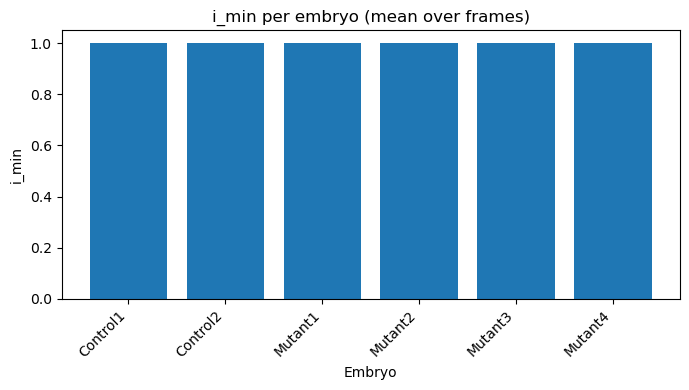

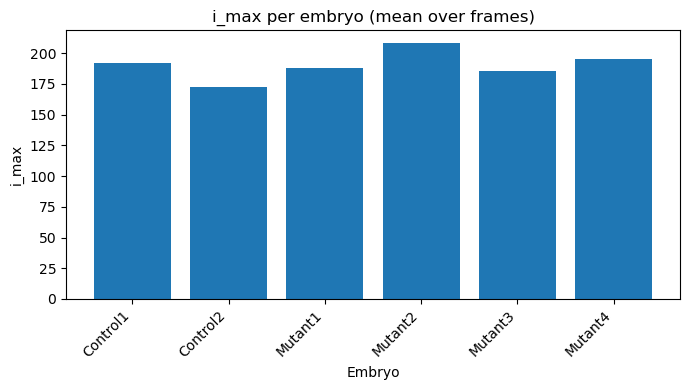

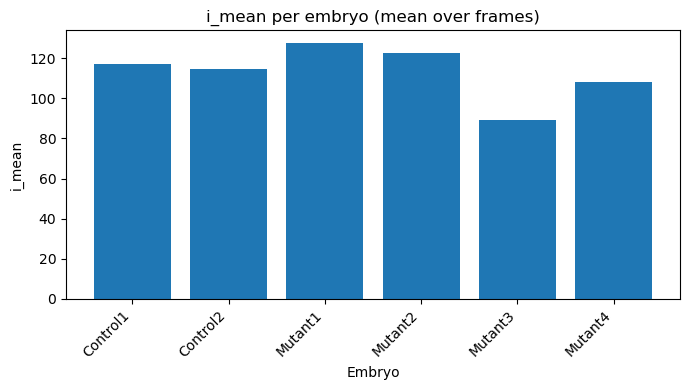

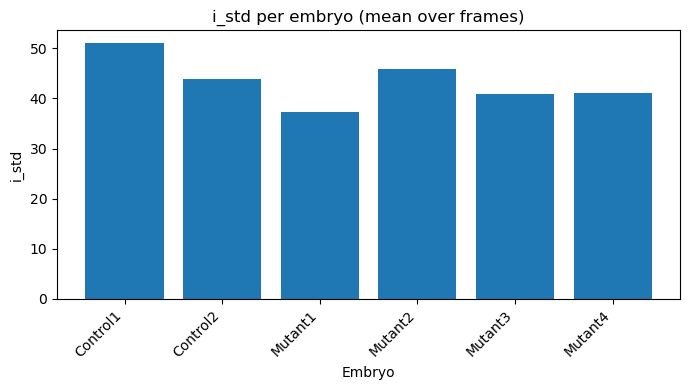

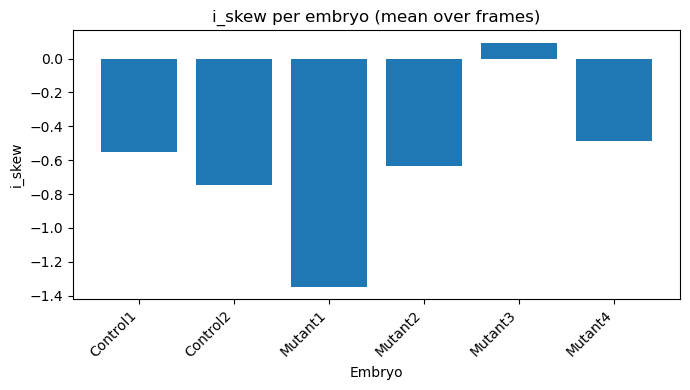

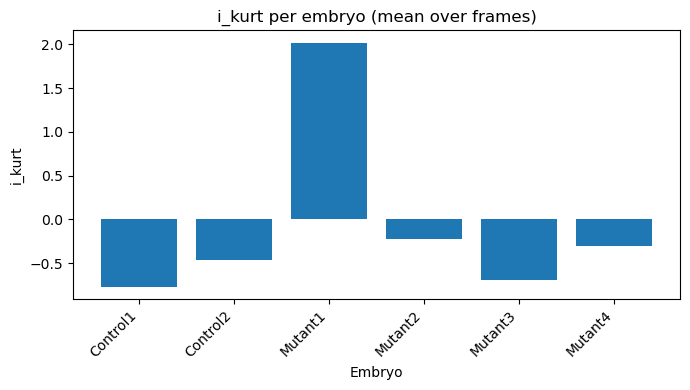

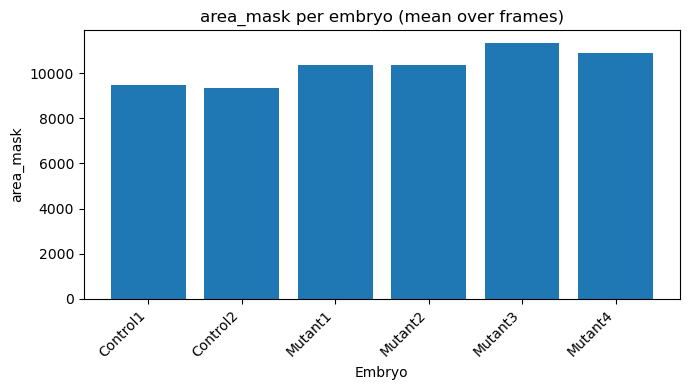

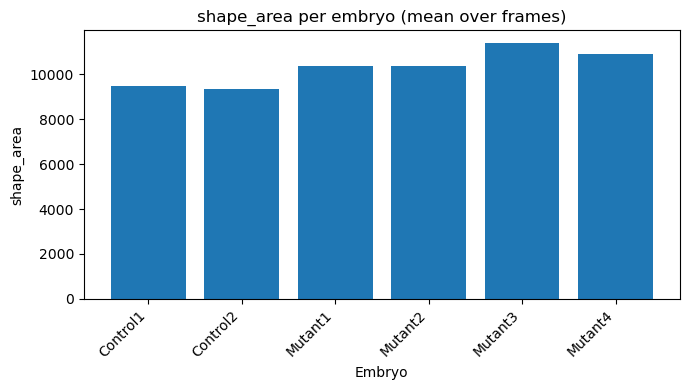

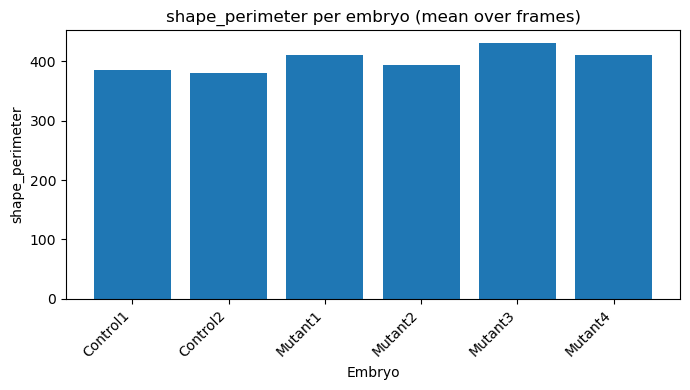

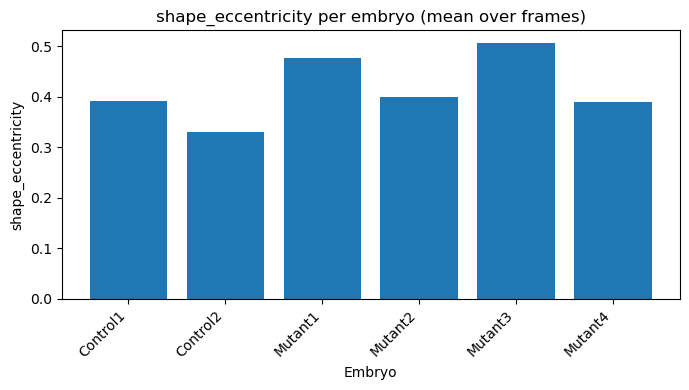

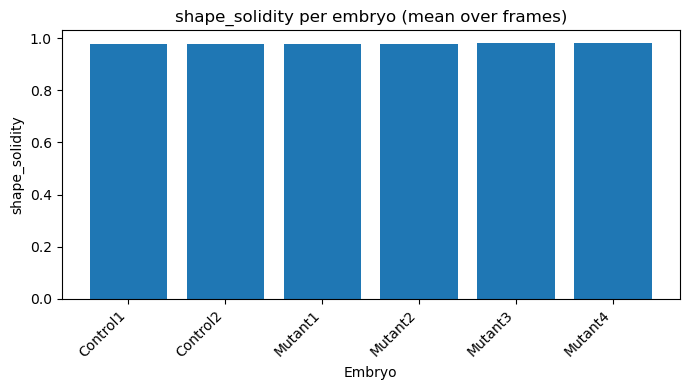

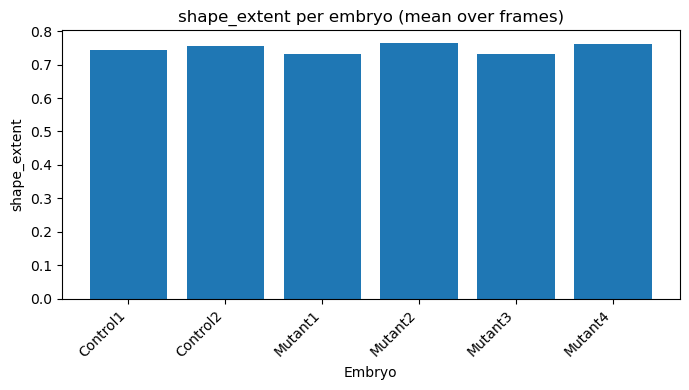

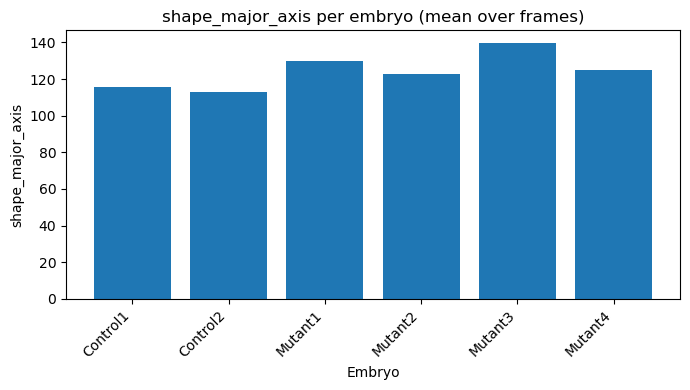

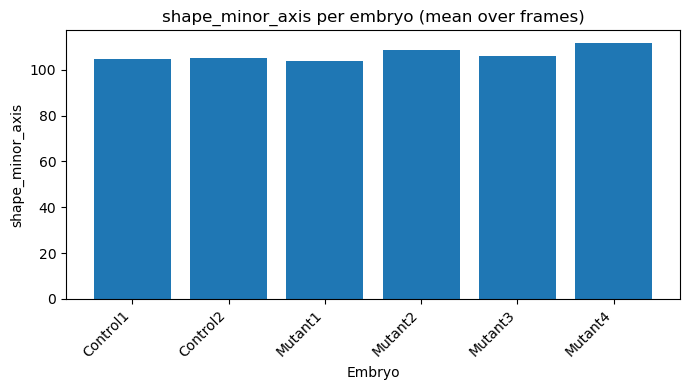

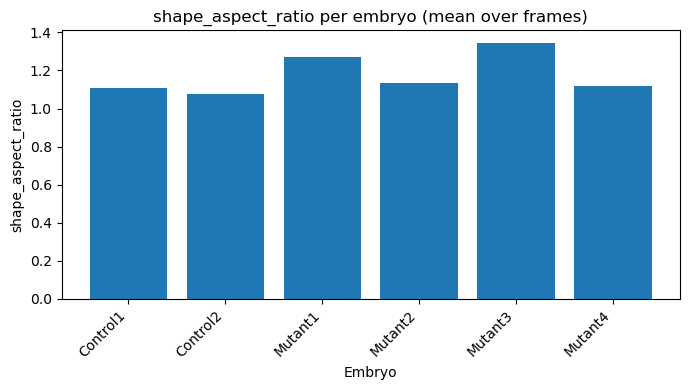

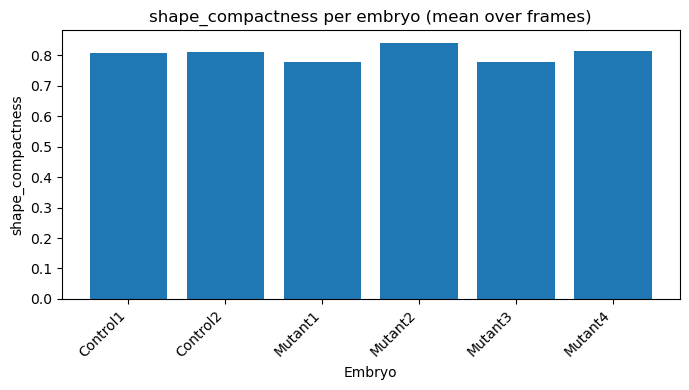

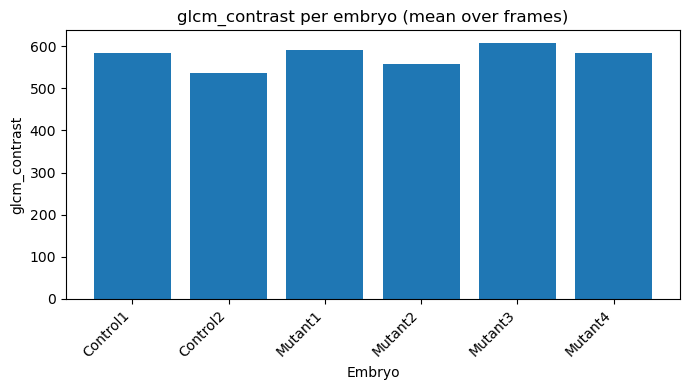

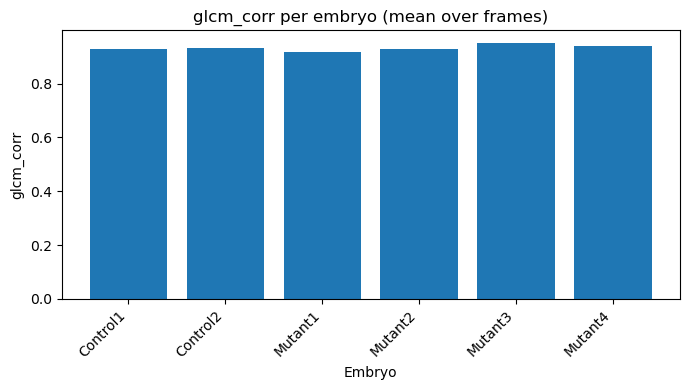

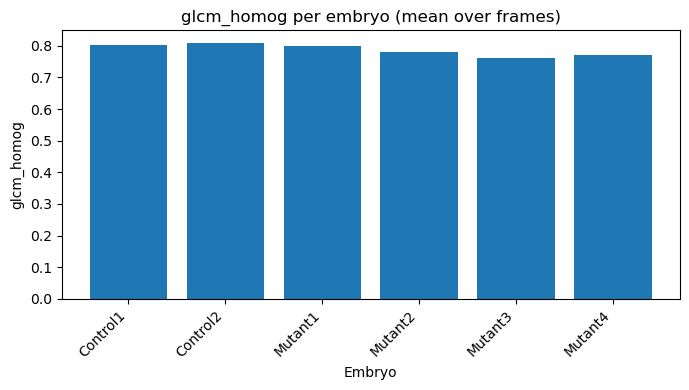

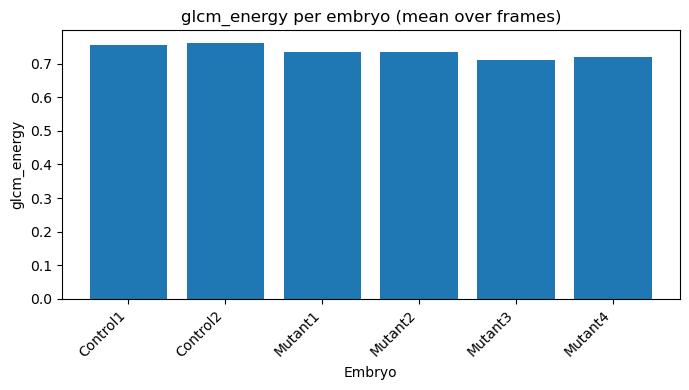

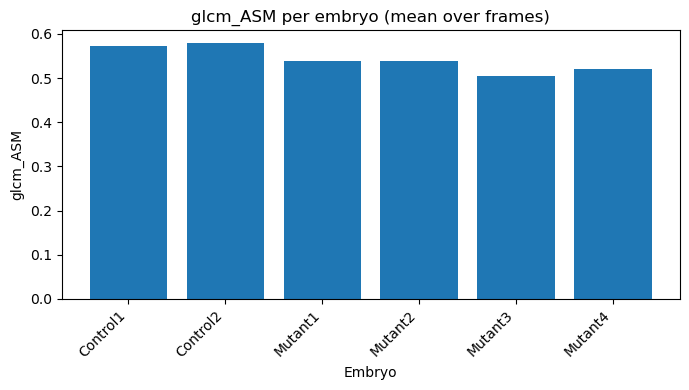

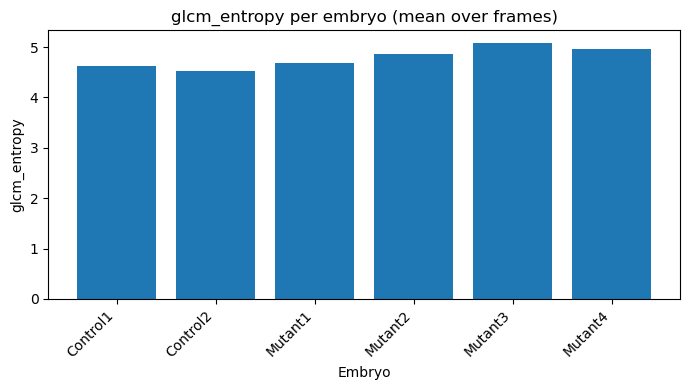

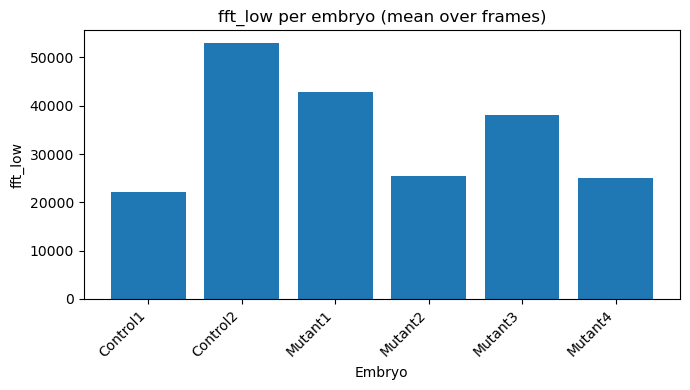

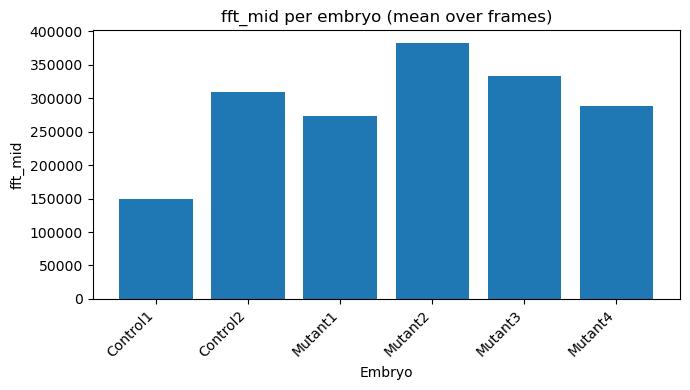

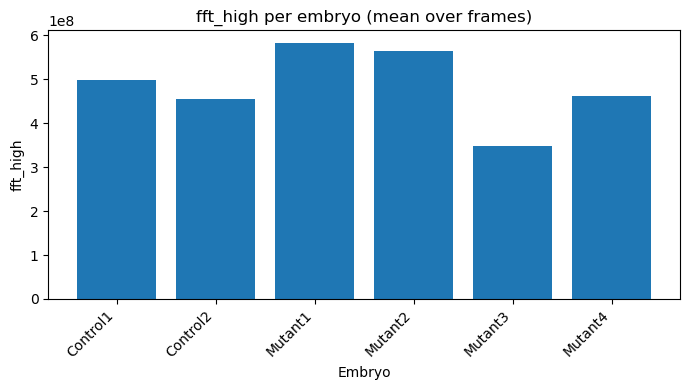

In [13]:
# Choose the 6 embryos you care about
embryos = sorted(df["embryo_id"].unique())[:6]

# All numeric features
num_feats = [c for c in df.columns 
             if c not in ["embryo_id", "frame_idx", "genotype", "group"]]

for feat in num_feats:
    plt.figure(figsize=(7, 4))

    # Example: use the mean of the feature over all frames of each embryo
    summary = (
        df[df["embryo_id"].isin(embryos)]
        .groupby("embryo_id")[feat]
        .mean()
        .reindex(embryos)   # keep embryo order fixed
    )

    # x = embryos, y = feature value
    x_pos = np.arange(len(embryos))
    plt.bar(x_pos, summary.values)

    plt.xticks(x_pos, embryos, rotation=45, ha="right")
    plt.ylabel(feat)
    plt.xlabel("Embryo")
    plt.title(f"{feat} per embryo (mean over frames)")
    plt.tight_layout()
    plt.show()

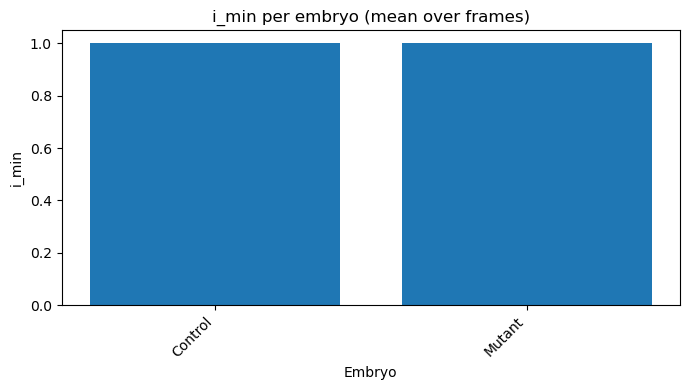

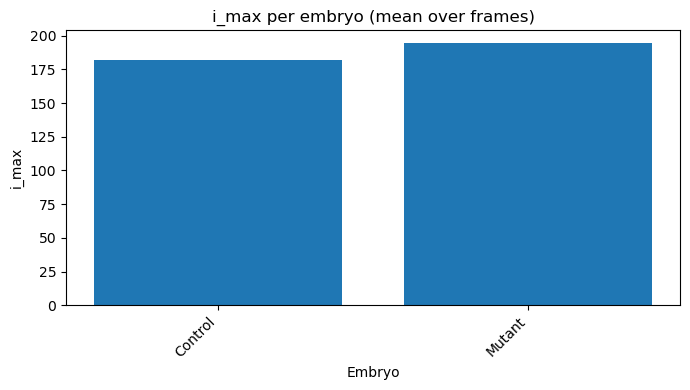

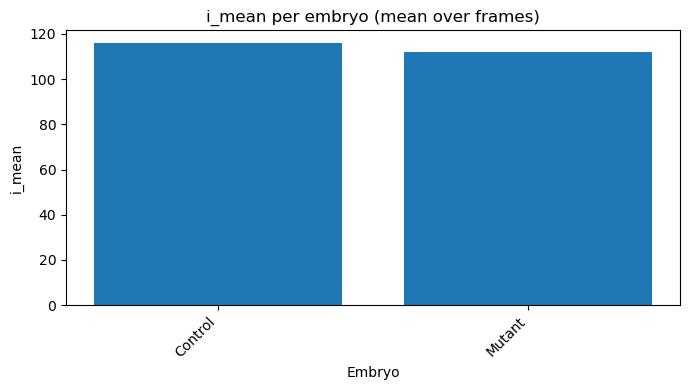

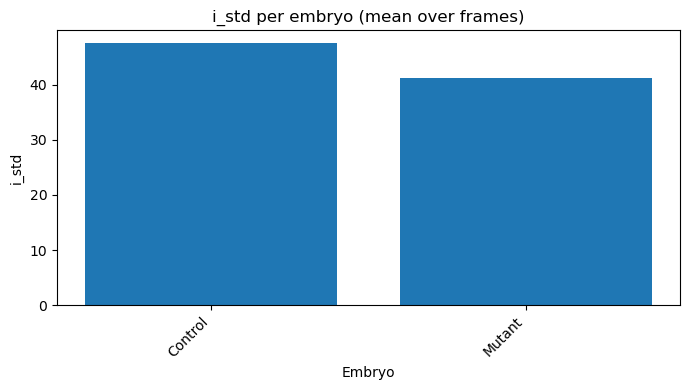

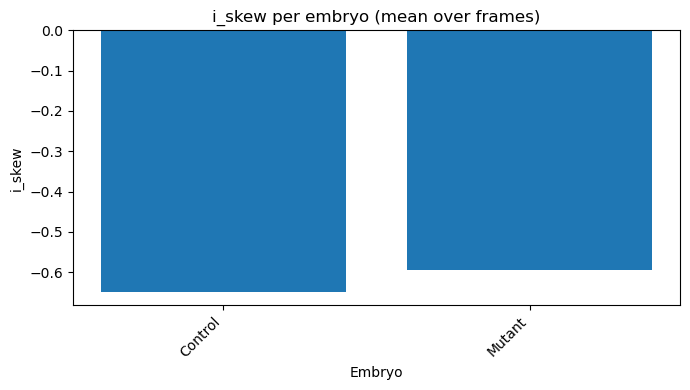

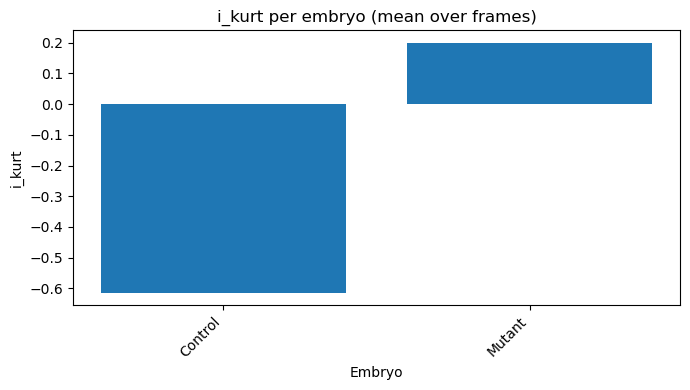

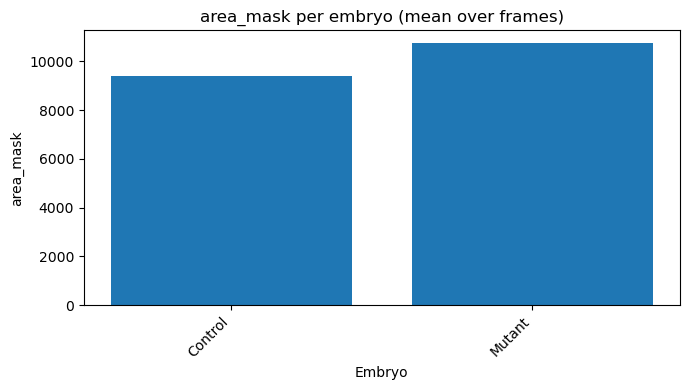

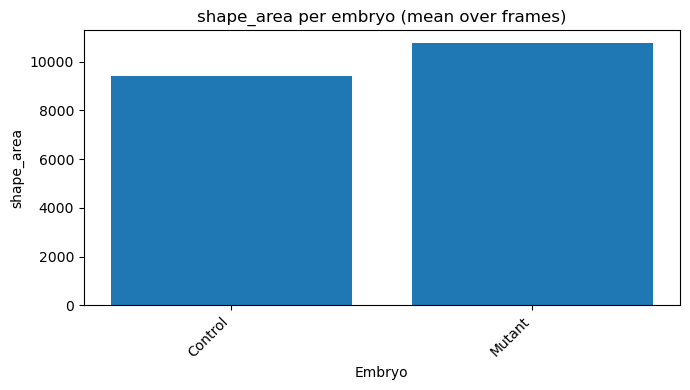

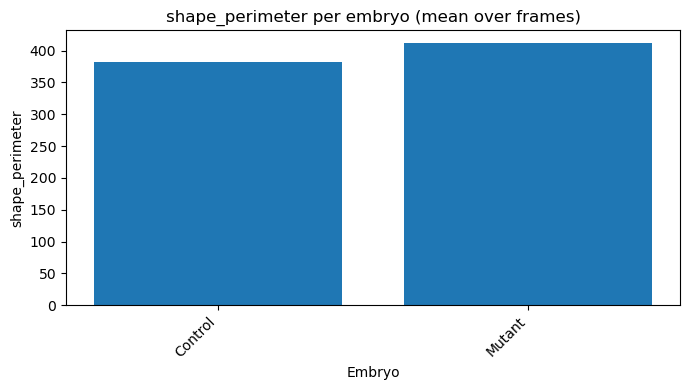

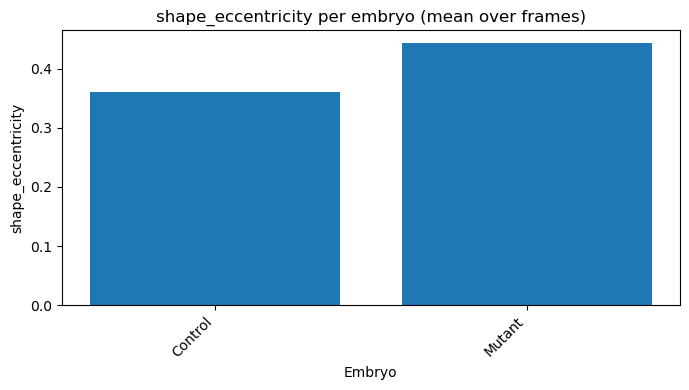

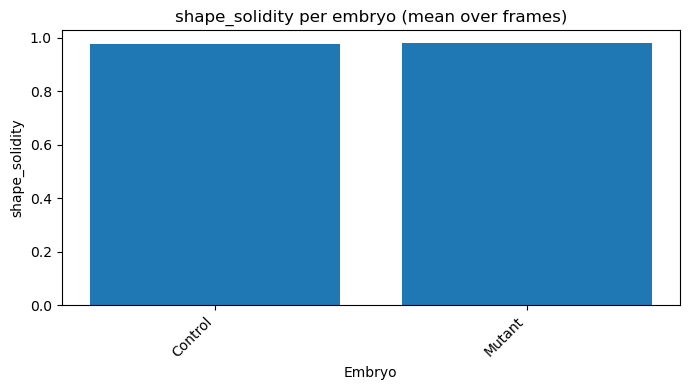

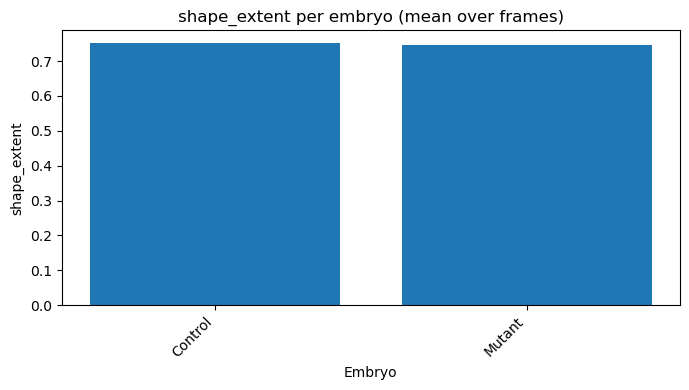

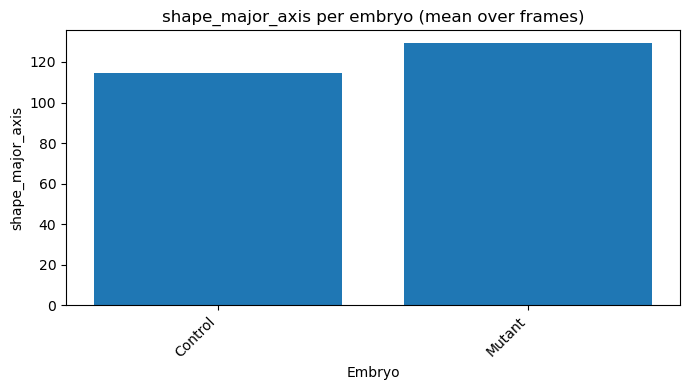

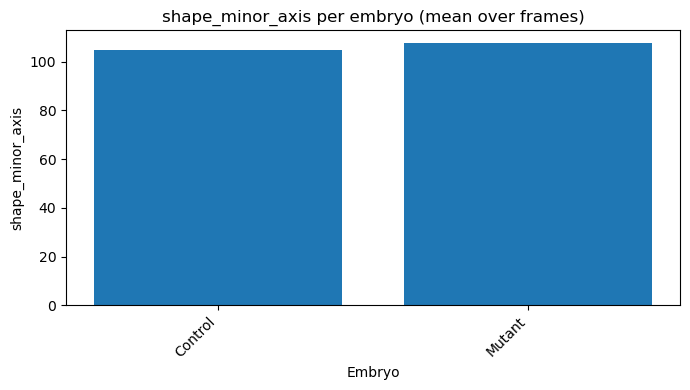

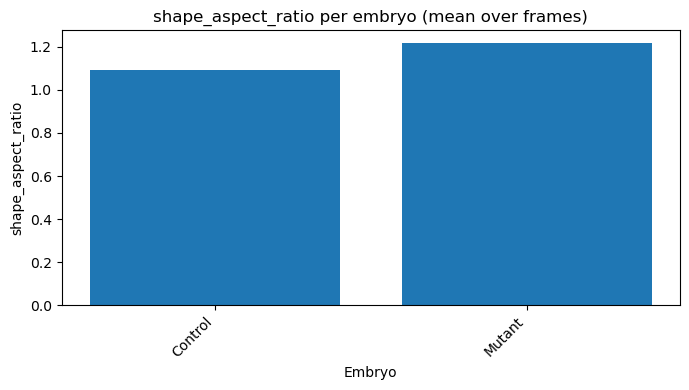

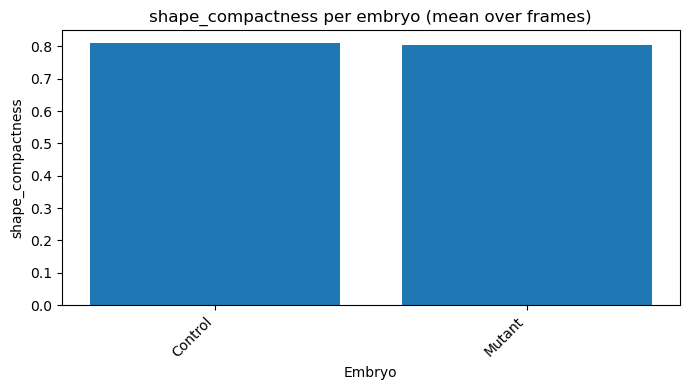

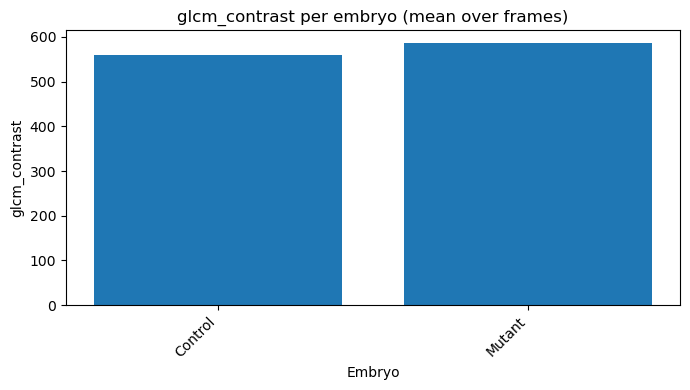

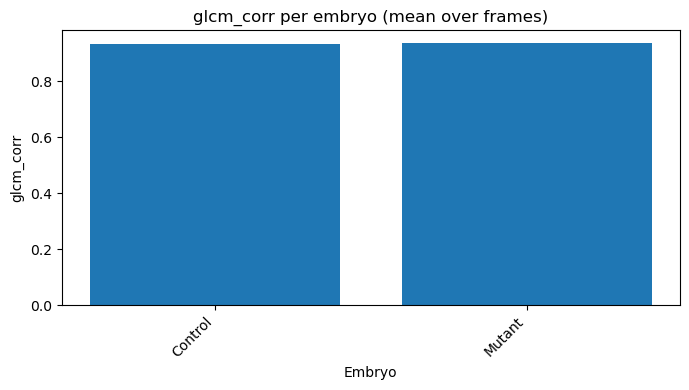

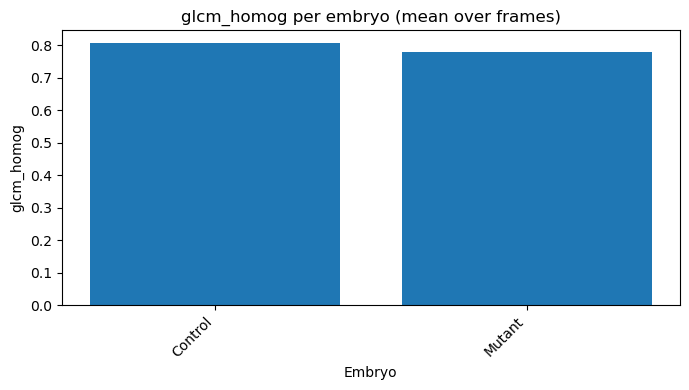

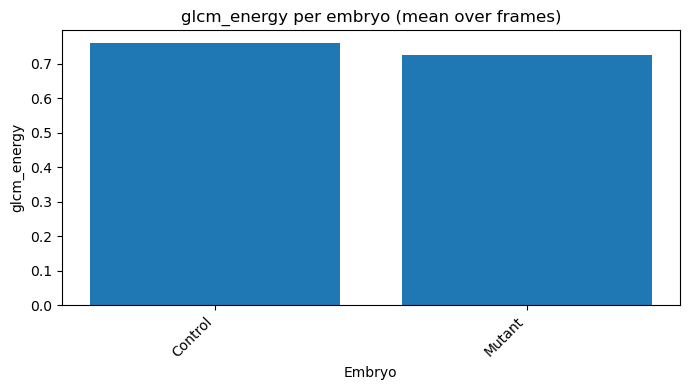

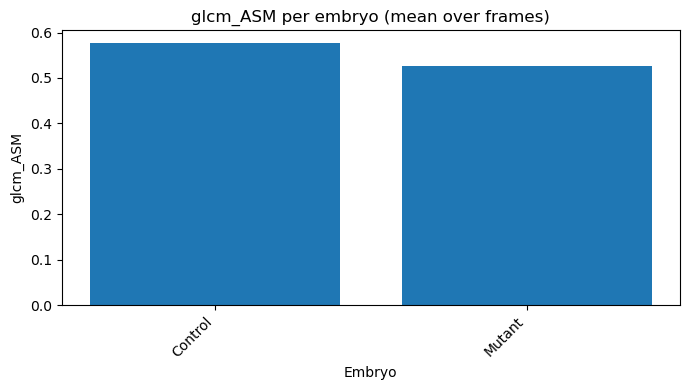

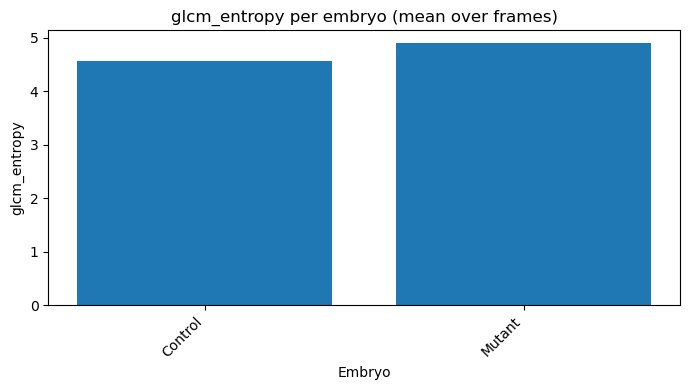

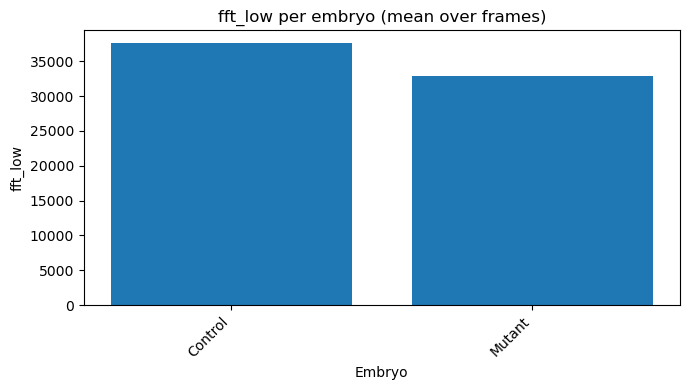

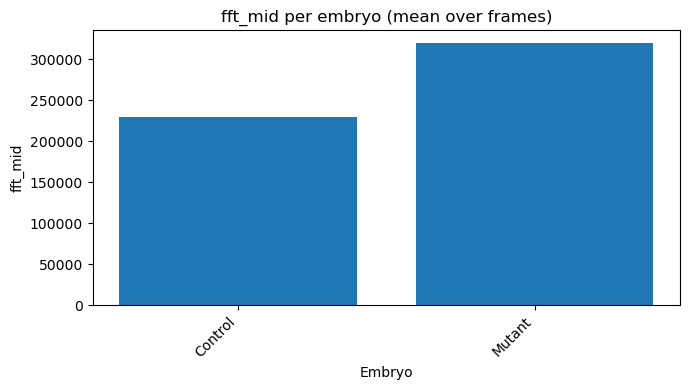

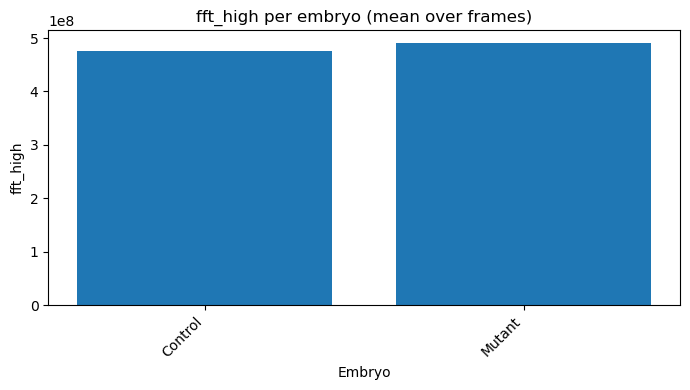

In [14]:
# Choose the 6 embryos you care about
embryos = sorted(df["genotype"].unique())[:6]

# All numeric features
num_feats = [c for c in df.columns 
             if c not in ["embryo_id", "frame_idx", "genotype", "group"]]

for feat in num_feats:
    plt.figure(figsize=(7, 4))

    # Example: use the mean of the feature over all frames of each embryo
    summary = (
        df[df["genotype"].isin(embryos)]
        .groupby("genotype")[feat]
        .mean()
        .reindex(embryos)   # keep embryo order fixed
    )

    # x = embryos, y = feature value
    x_pos = np.arange(len(embryos))
    plt.bar(x_pos, summary.values)

    plt.xticks(x_pos, embryos, rotation=45, ha="right")
    plt.ylabel(feat)
    plt.xlabel("Embryo")
    plt.title(f"{feat} per embryo (mean over frames)")
    plt.tight_layout()
    plt.show()

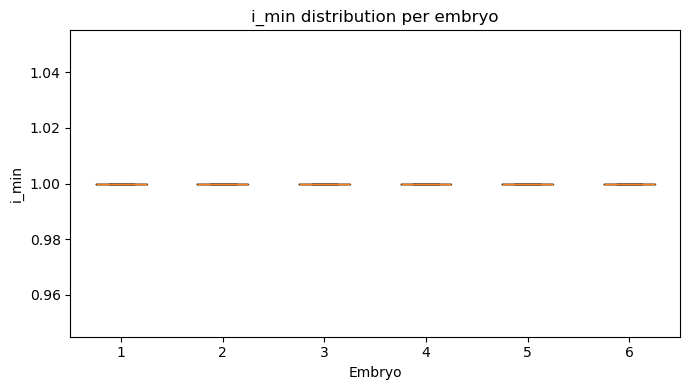

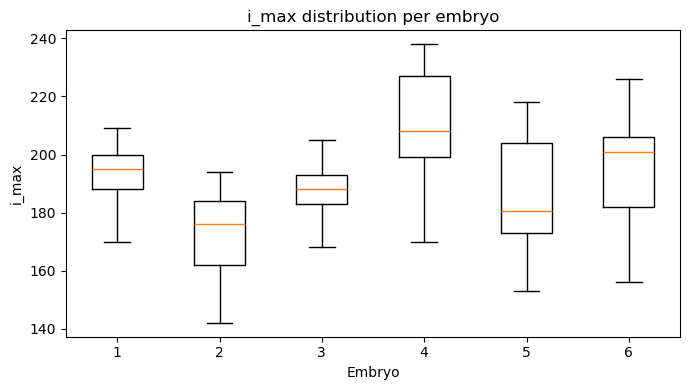

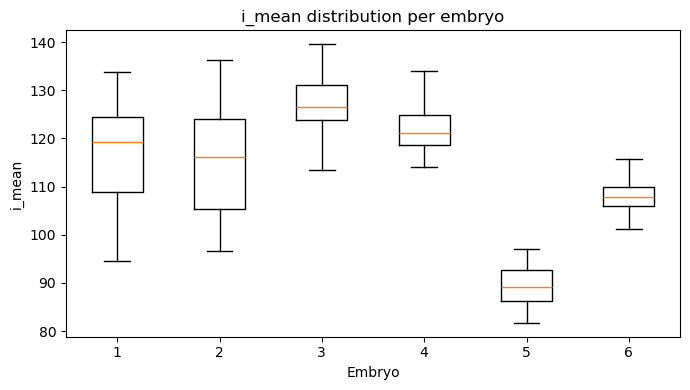

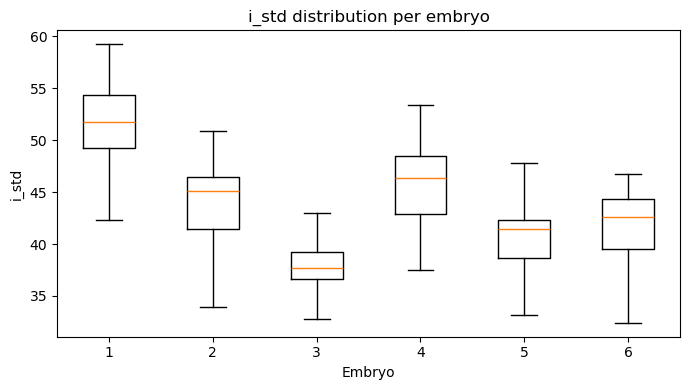

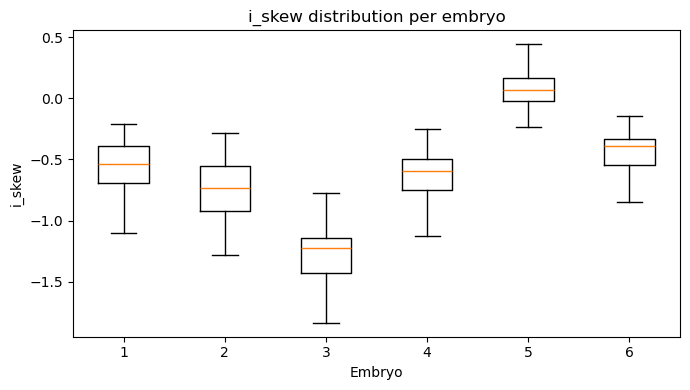

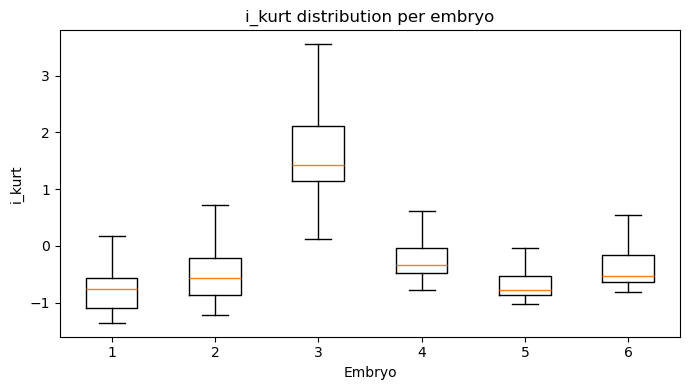

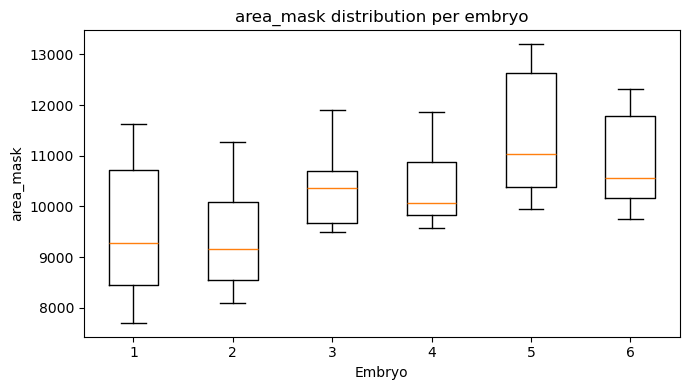

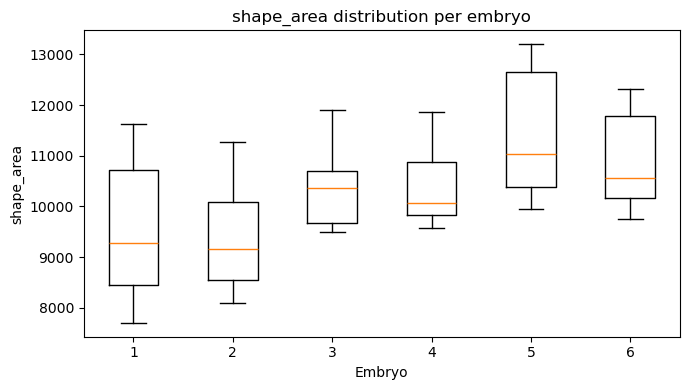

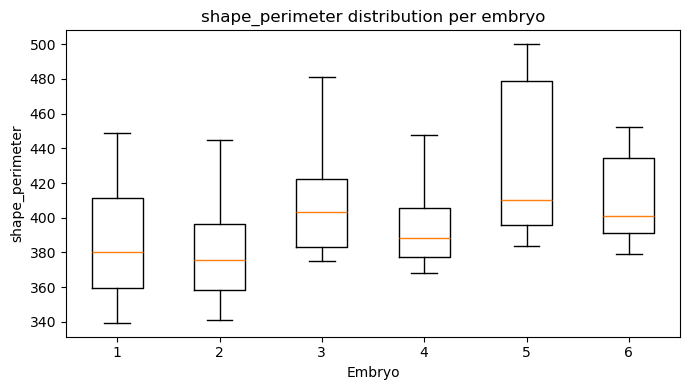

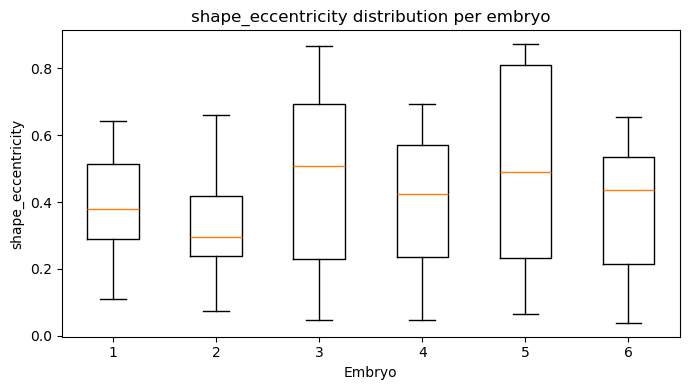

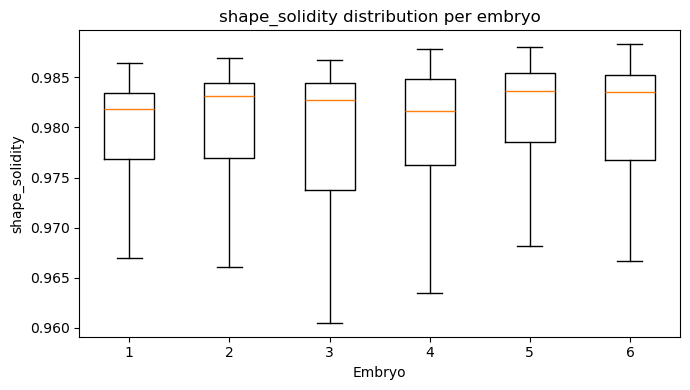

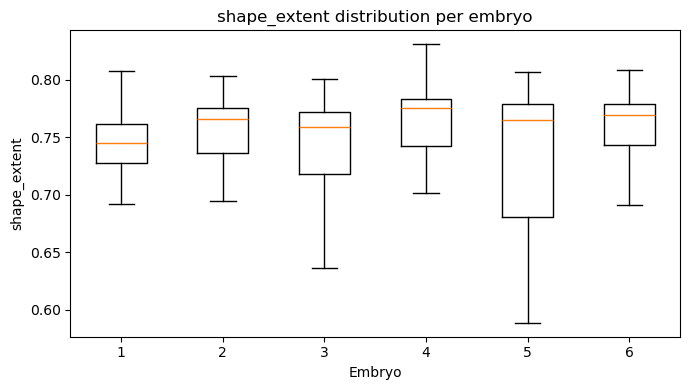

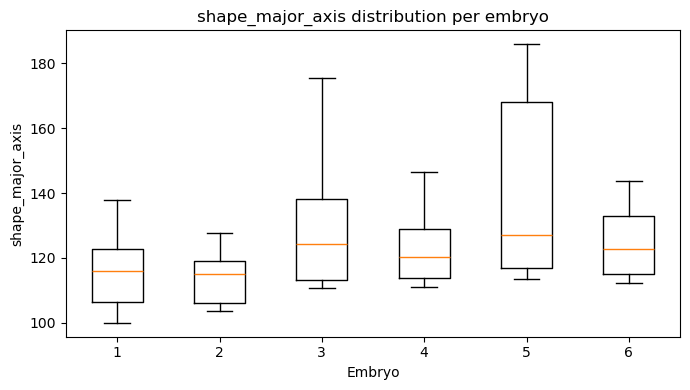

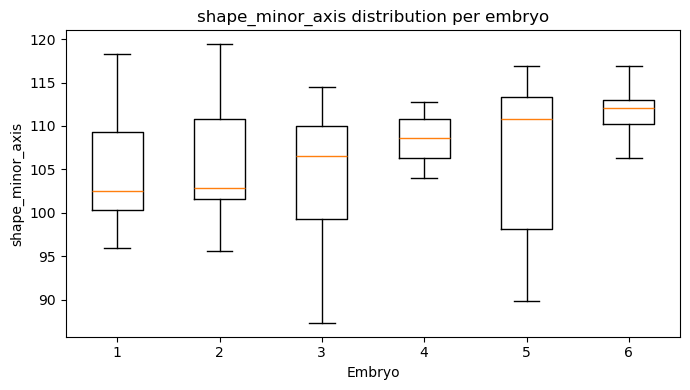

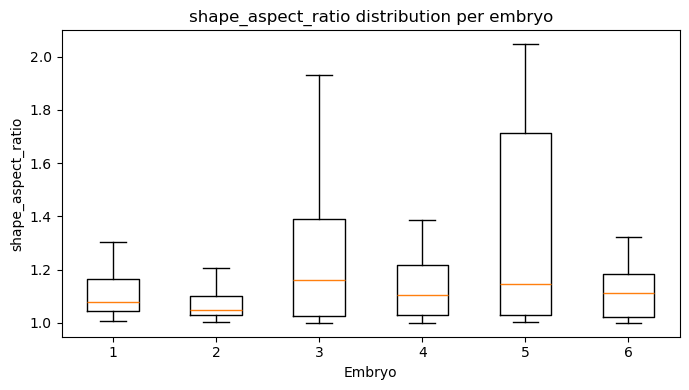

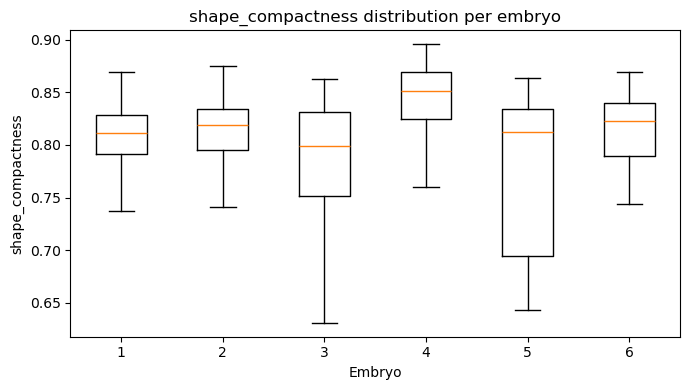

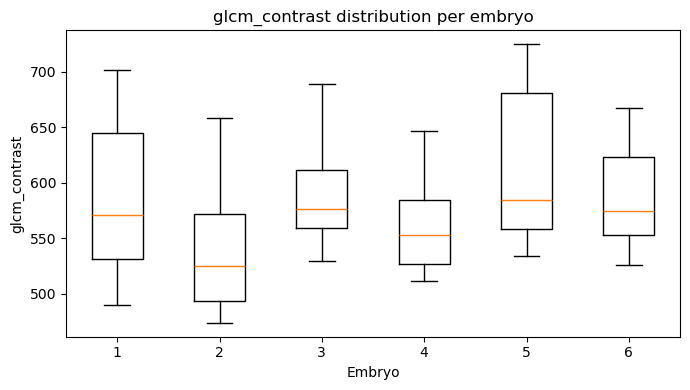

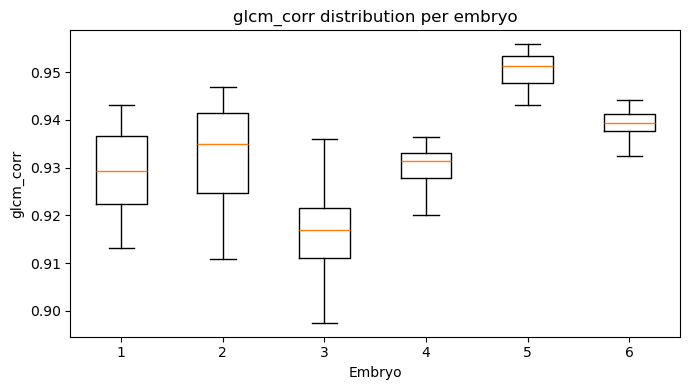

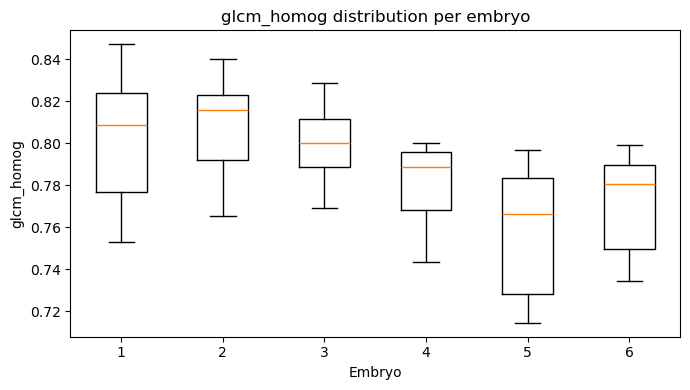

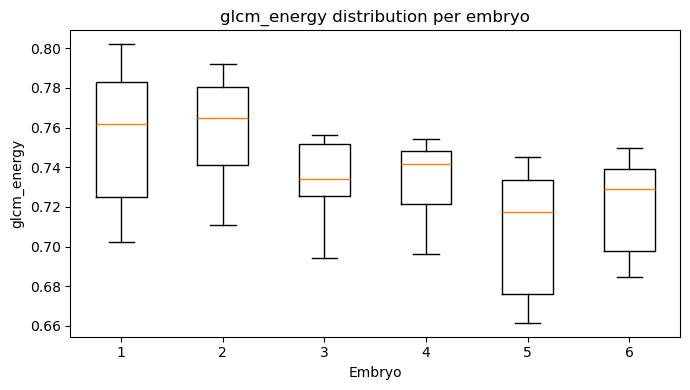

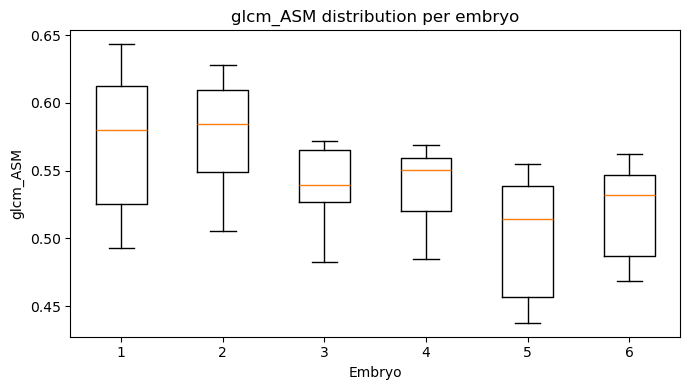

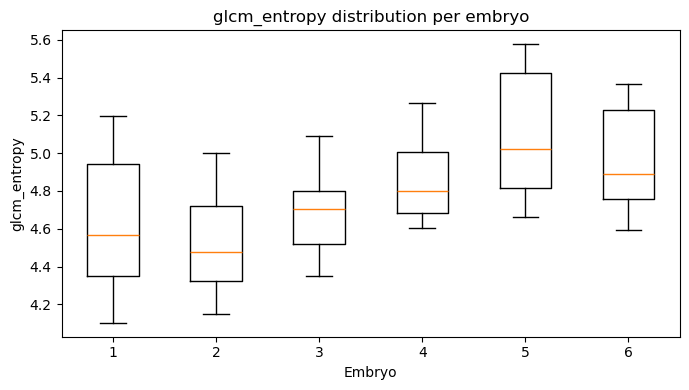

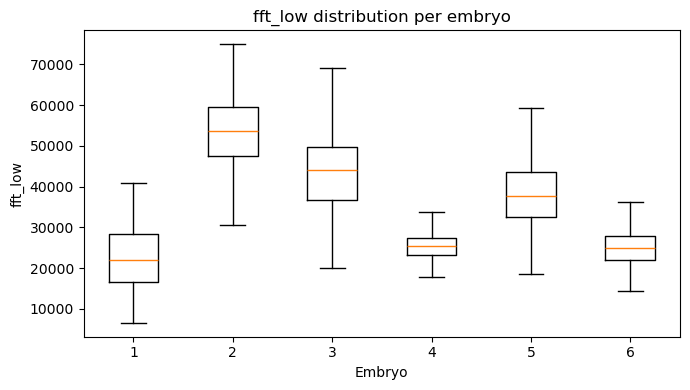

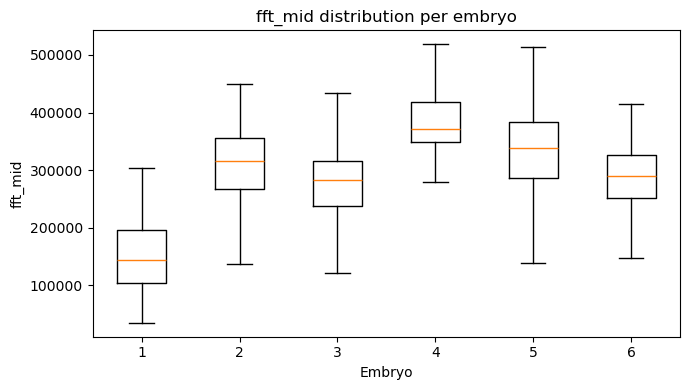

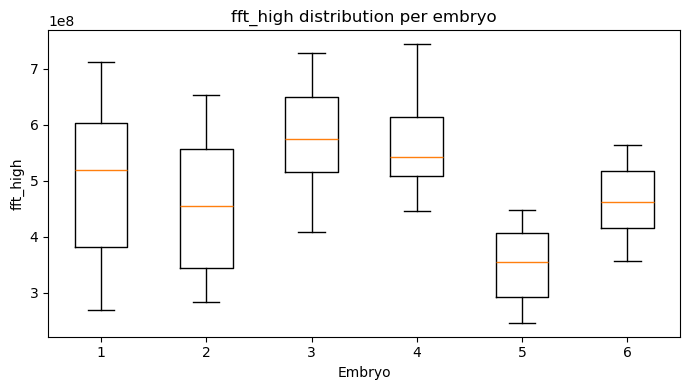

In [15]:
embryos = sorted(df["embryo_id"].unique())[:6]
num_feats = [c for c in df.columns 
             if c not in ["embryo_id", "frame_idx", "genotype", "group"]]

for feat in num_feats:
    plt.figure(figsize=(7, 4))

    data_per_embryo = [
        df.loc[df["embryo_id"] == emb, feat].dropna().values
        for emb in embryos
    ]

    plt.boxplot(data_per_embryo, showfliers=False)
    plt.ylabel(feat)
    plt.xlabel("Embryo")
    plt.title(f"{feat} distribution per embryo")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_7959/364086386.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (6,4))


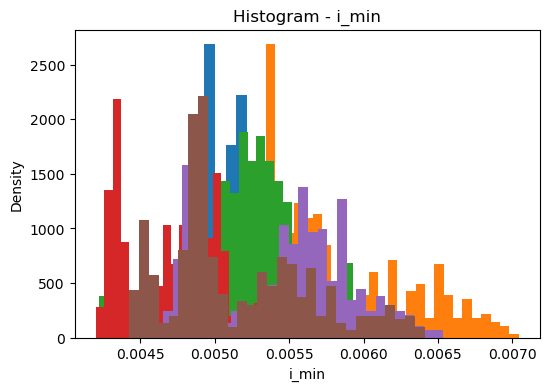

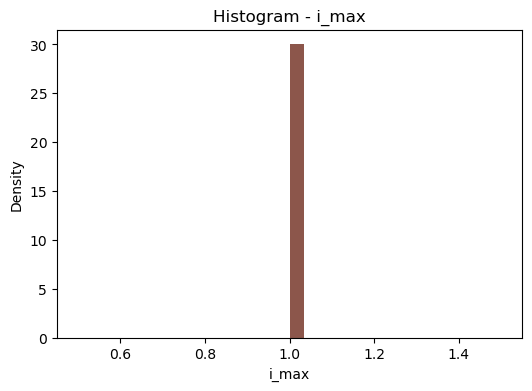

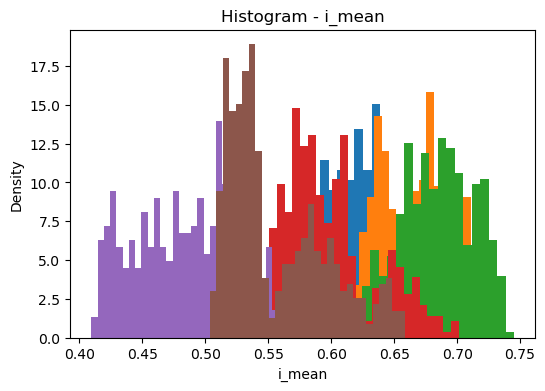

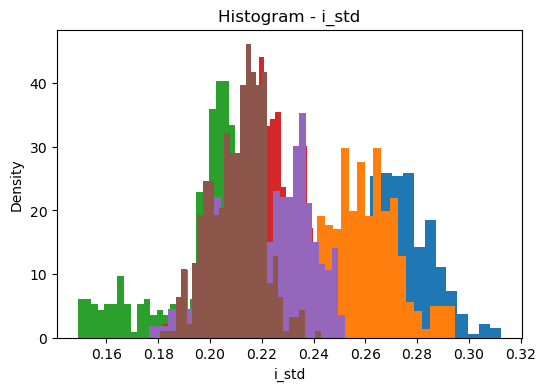

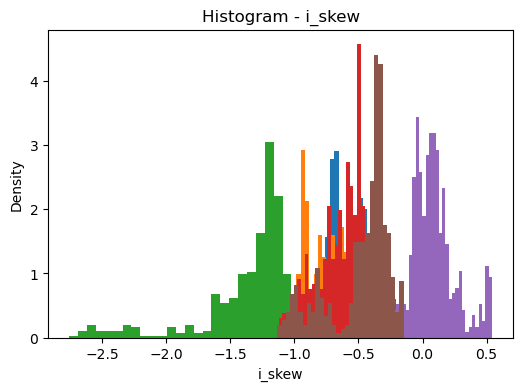

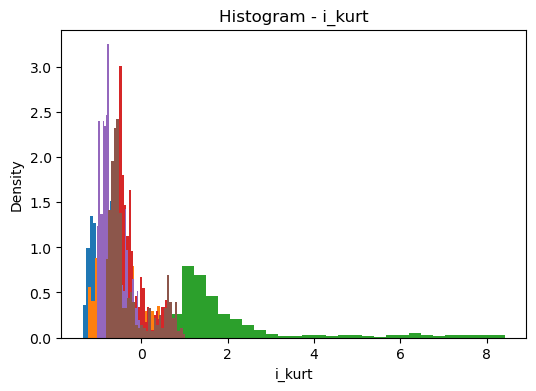

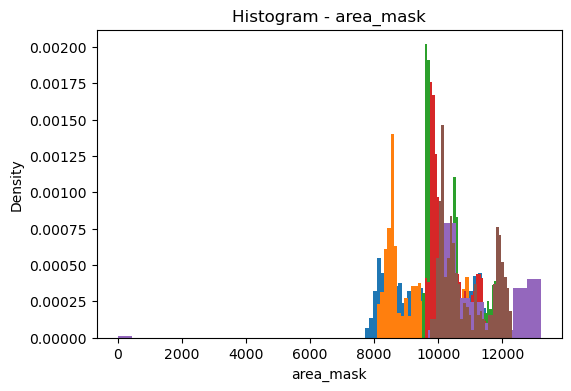

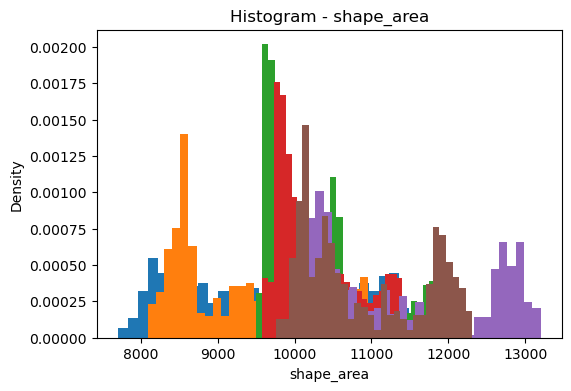

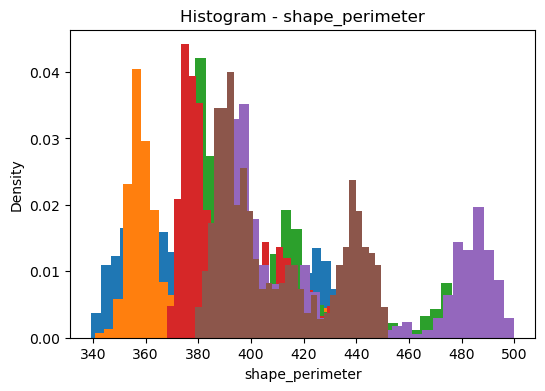

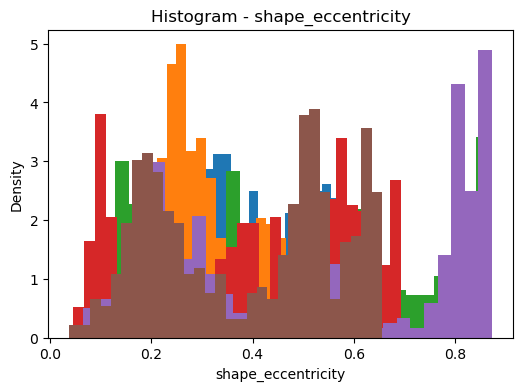

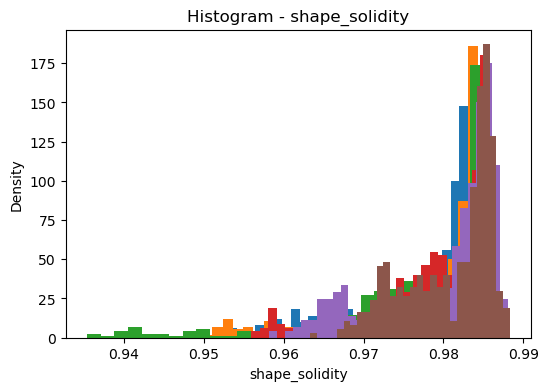

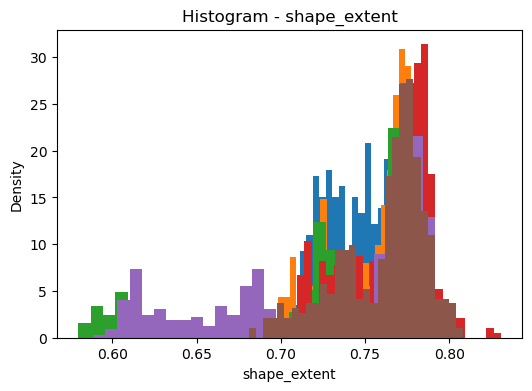

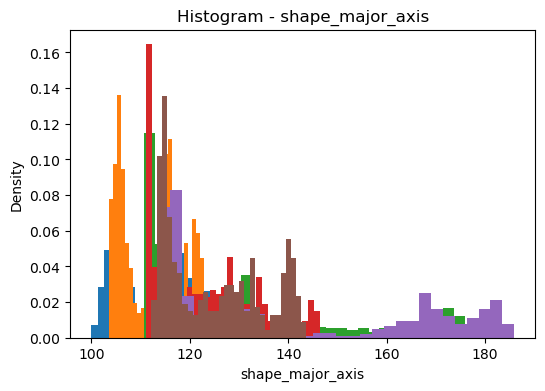

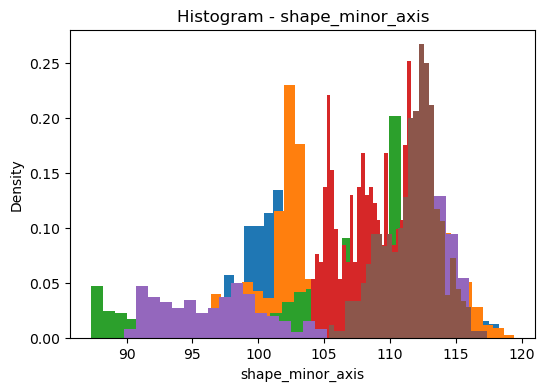

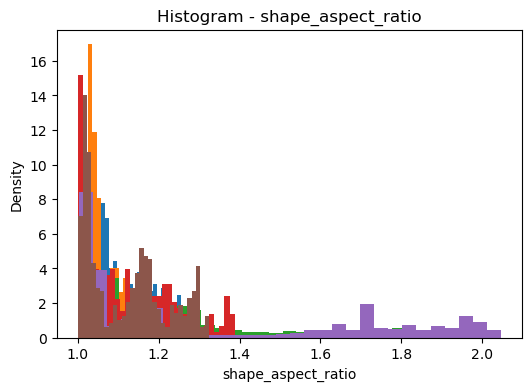

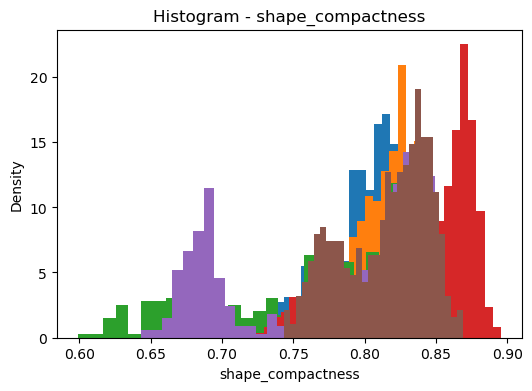

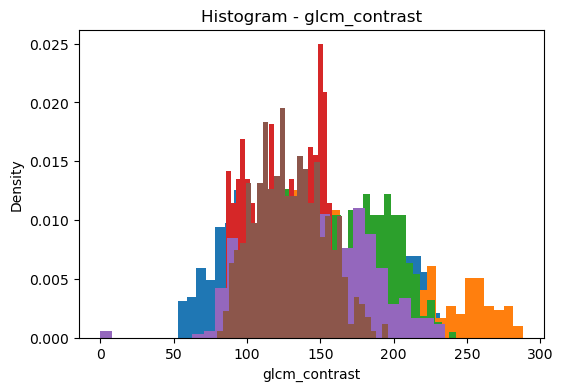

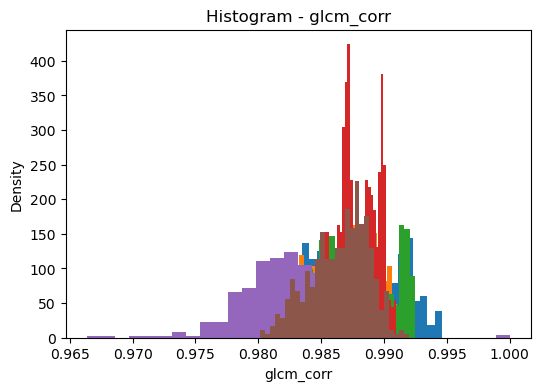

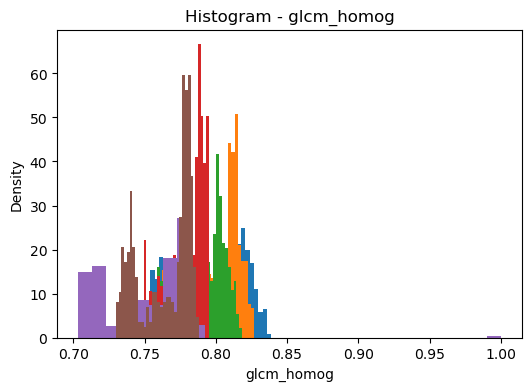

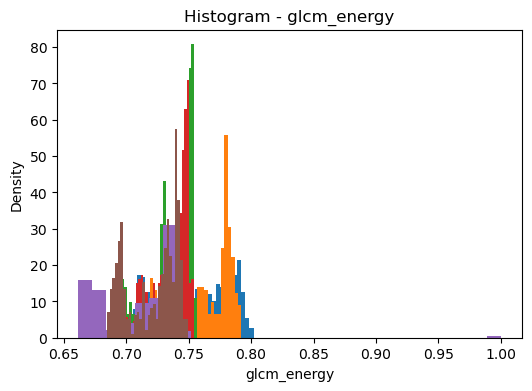

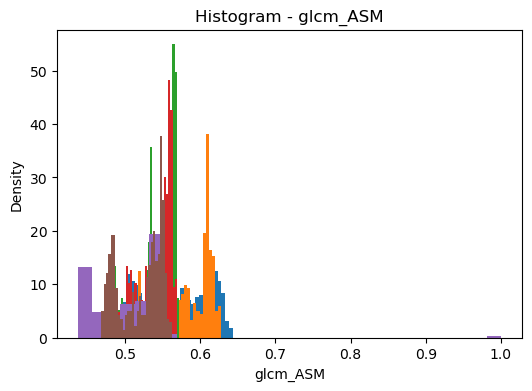

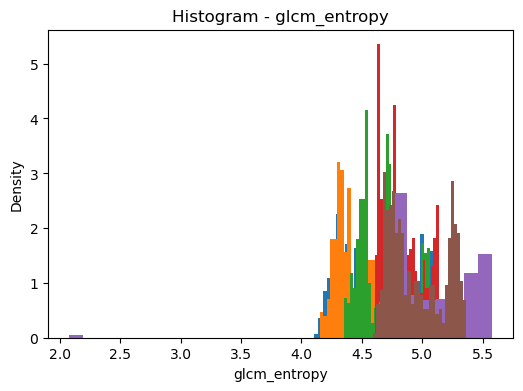

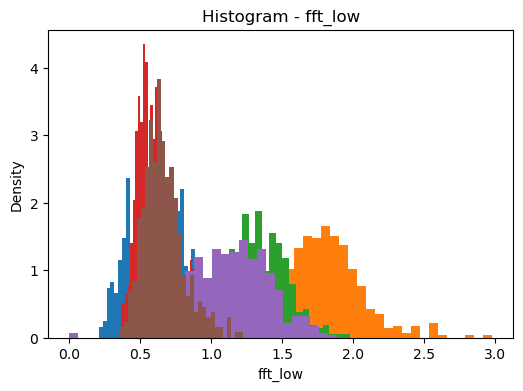

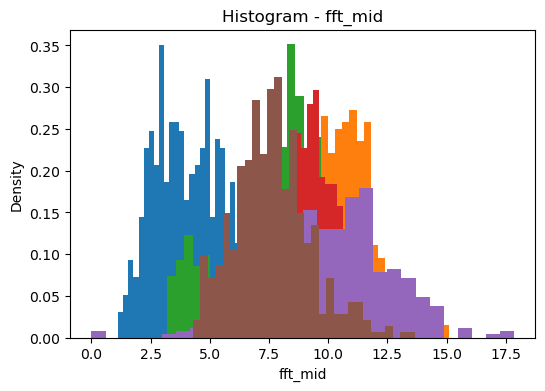

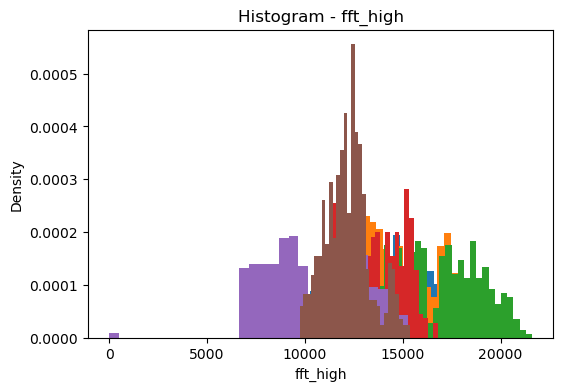

In [28]:
#Select numeric features
num_feats = [c for c in df.columns if c not in ["embryo_id", "frame_idx", "genotype", "group"]]

embryos = df["embryo_id"].unique()

for feat in num_feats:
    plt.figure(figsize = (6,4))
    for emb in embryos:
        vals = df.loc[df["embryo_id"]== emb, feat].dropna()
        plt.hist(vals, bins=30, label=emb, density=True,)
    plt.title(f"Histogram - {feat}")
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.show

/tmp/ipykernel_7959/4242002841.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (6,4))


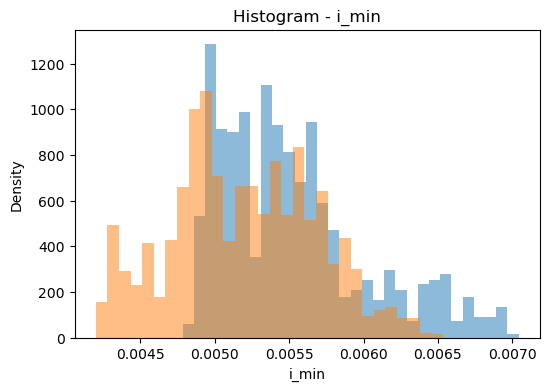

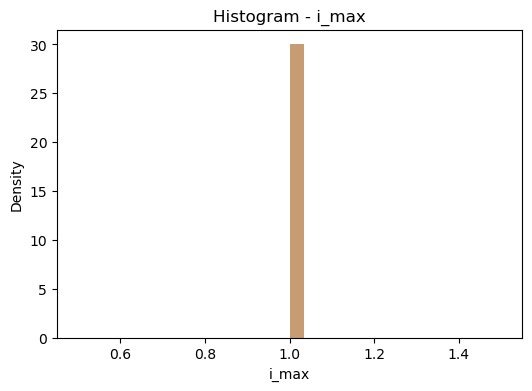

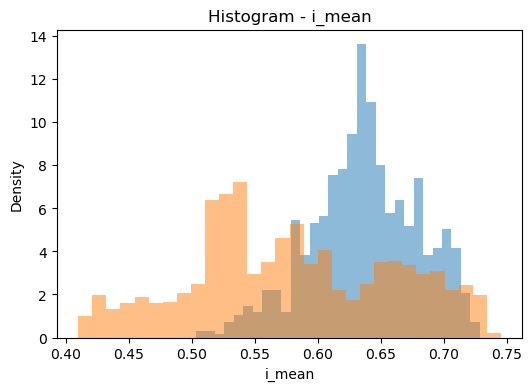

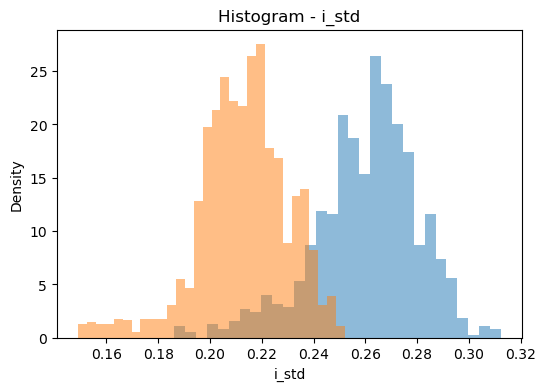

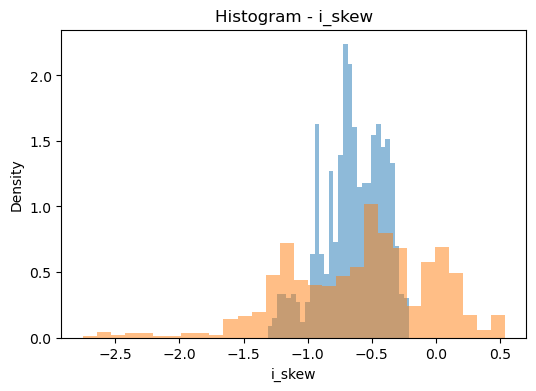

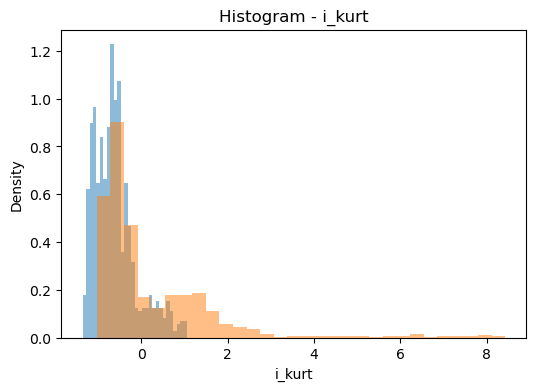

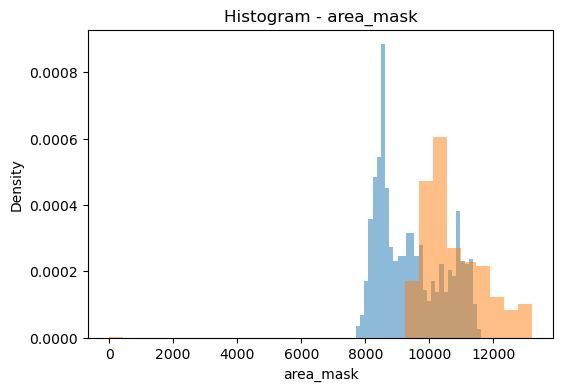

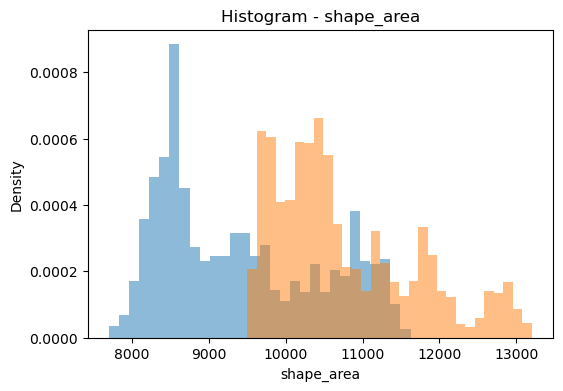

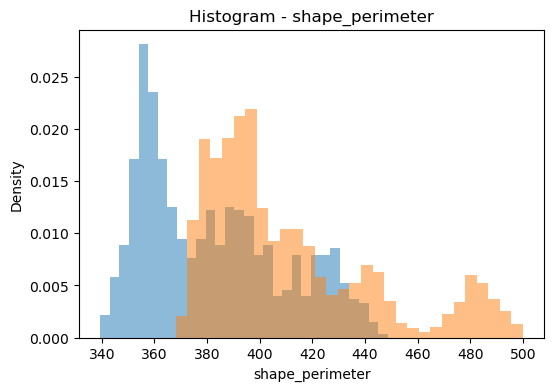

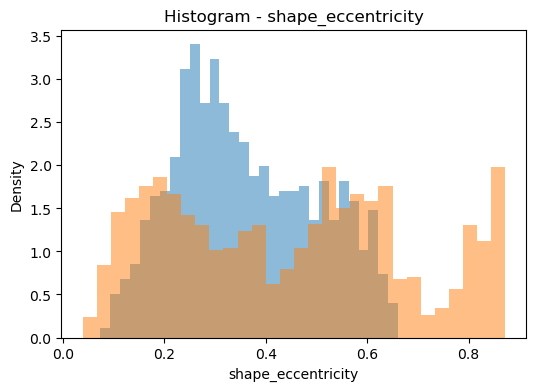

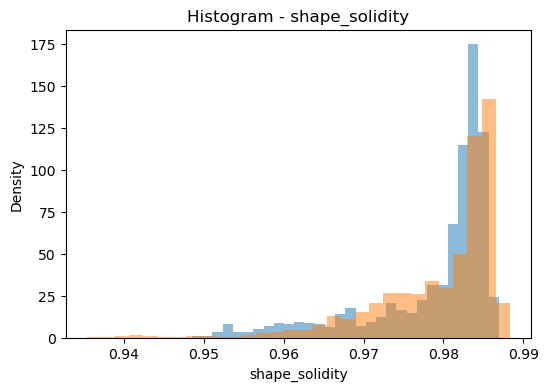

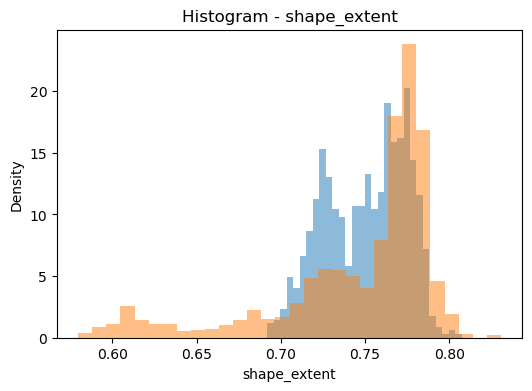

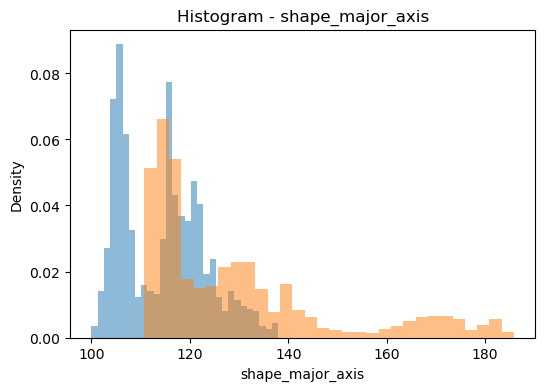

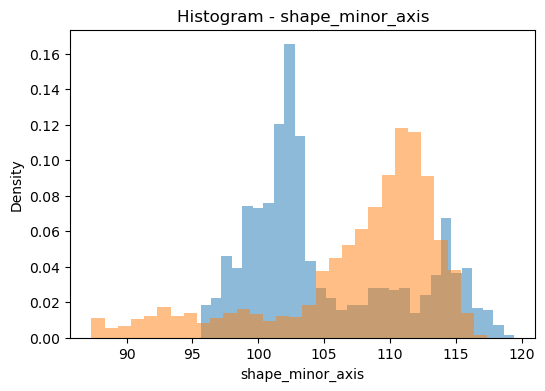

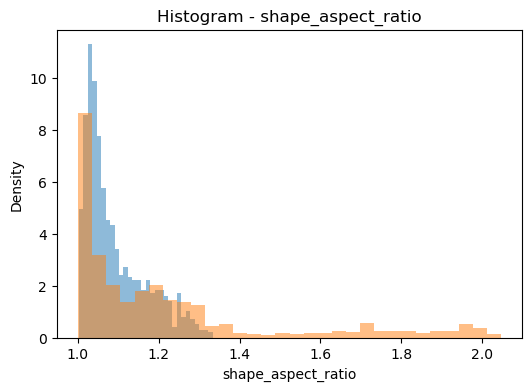

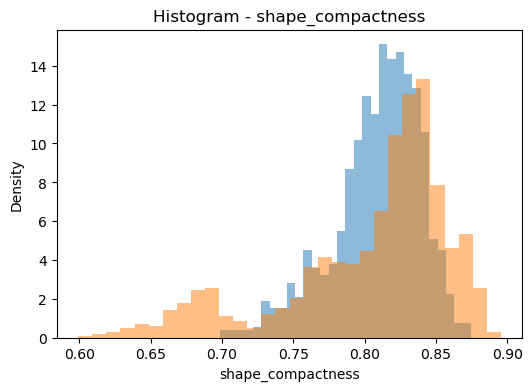

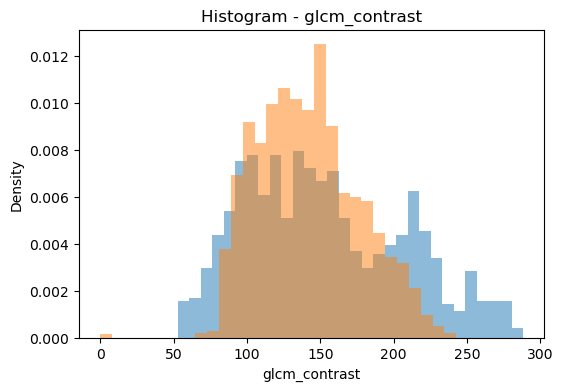

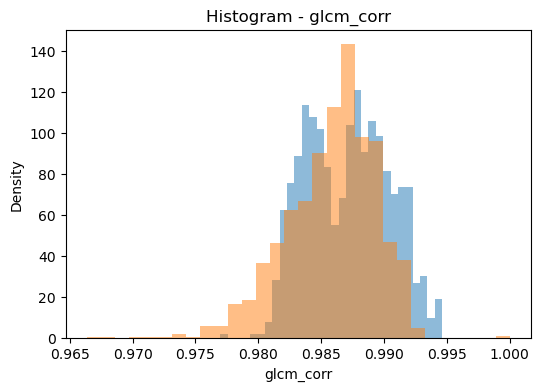

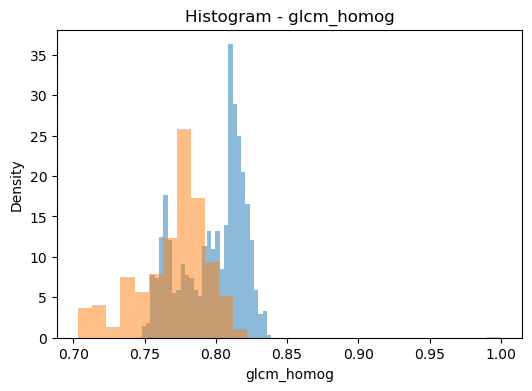

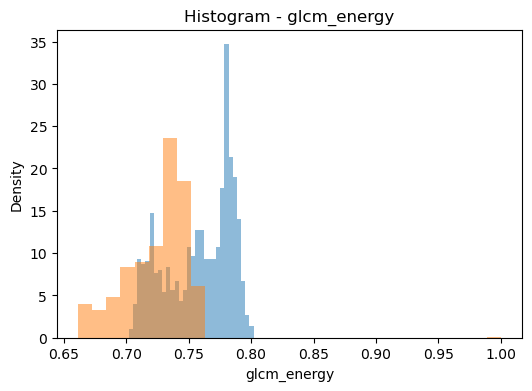

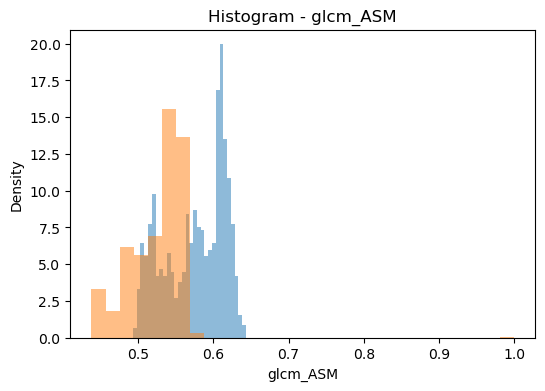

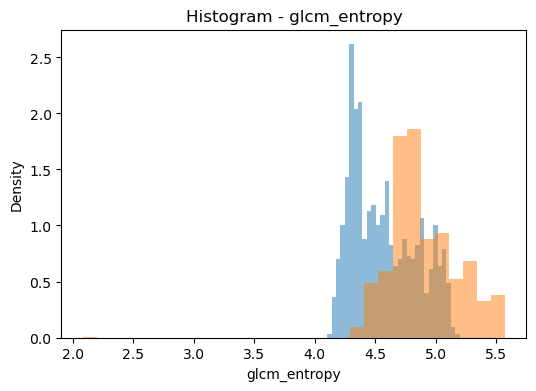

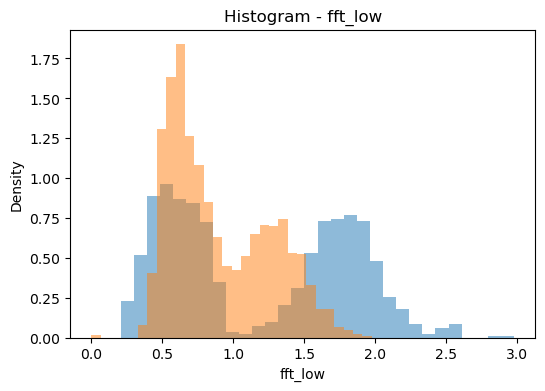

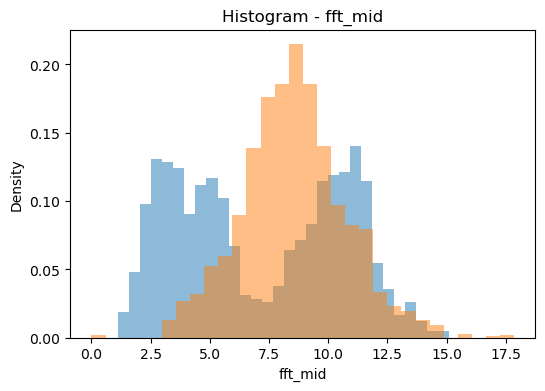

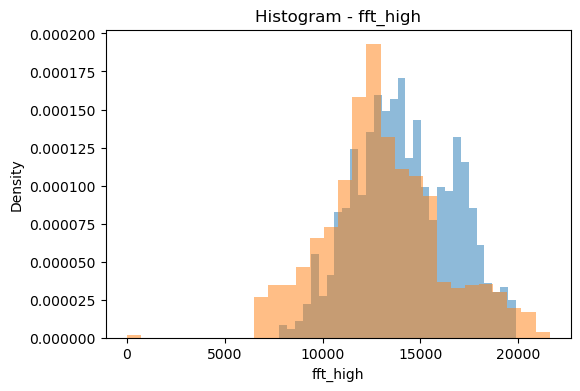

In [23]:
#Select numeric features
num_feats = [c for c in df.columns if c not in ["embryo_id", "frame_idx", "genotype", "group"]]

embryos = df["genotype"].unique()

for feat in num_feats:
    plt.figure(figsize = (6,4))
    for emb in embryos:
        vals = df.loc[df["genotype"]== emb, feat].dropna()
        plt.hist(vals, bins=30, alpha=0.5, label=emb, density=True)
    plt.title(f"Histogram - {feat}")
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.show

In [16]:
num_cols = df.select_dtypes(include=[float, int]).columns.tolist()
# remove colums as target/índices from X
for c in ["frame_idx"]:
    if c in num_cols:
        num_cols.remove(c)

X = df[num_cols].values
y = df["genotype"].values
groups = df["group"].values

# Remove rows with NaN on X
mask_ok = ~np.isnan(X).any(axis=1)
X = X[mask_ok]
y = y[mask_ok]
groups = groups[mask_ok]

X.shape, np.unique(y), len(np.unique(groups))

((2698, 25), array(['Control', 'Mutant'], dtype=object), 6)

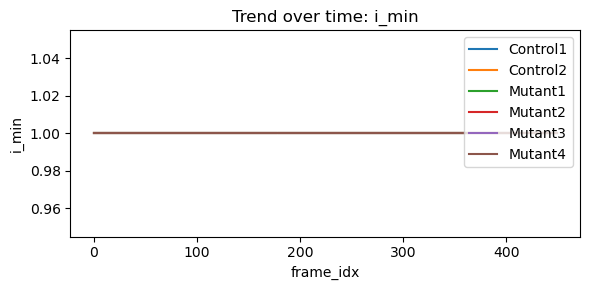

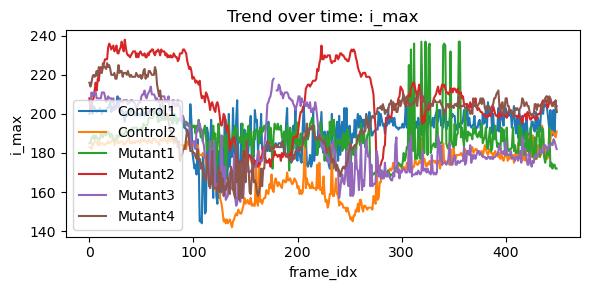

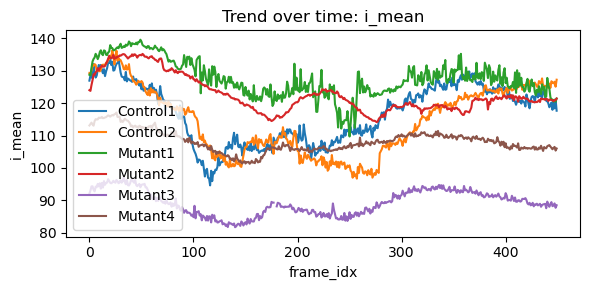

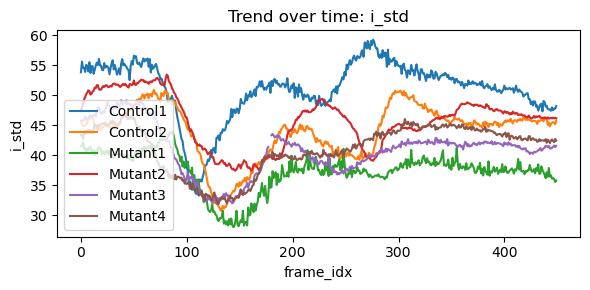

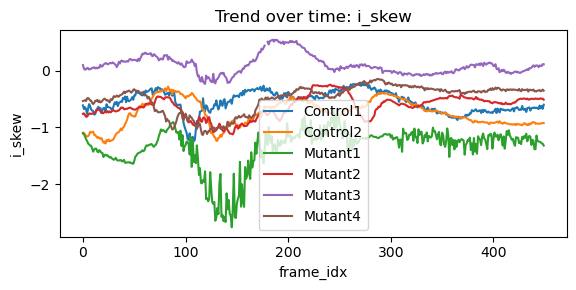

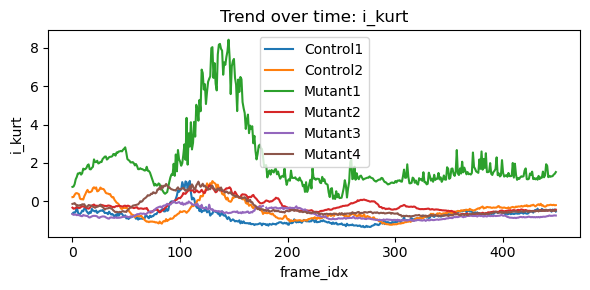

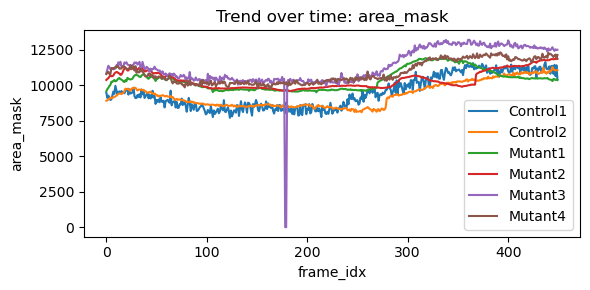

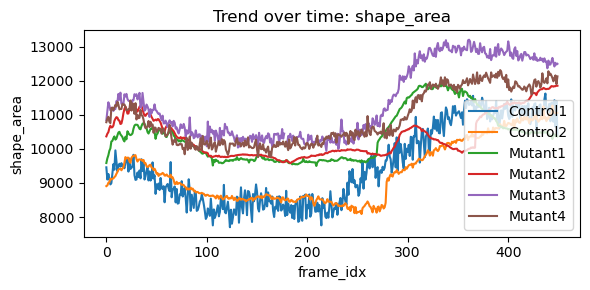

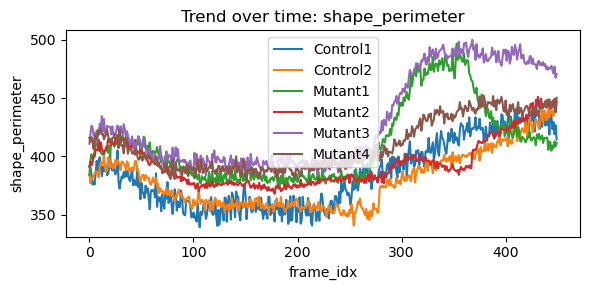

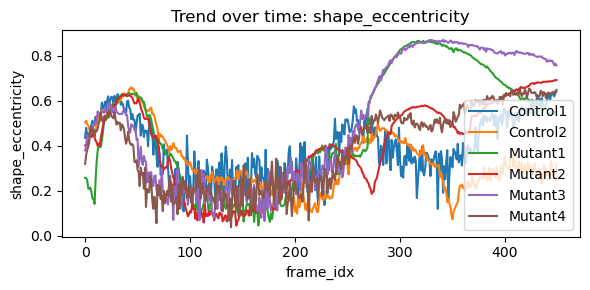

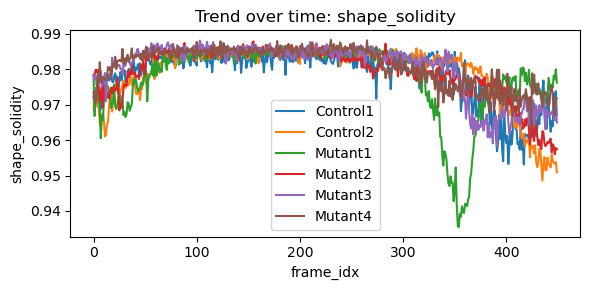

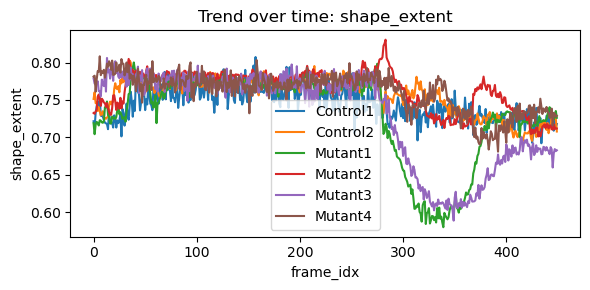

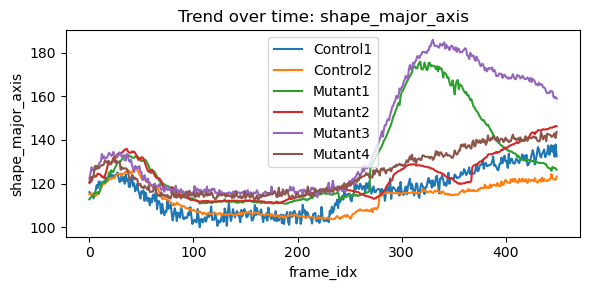

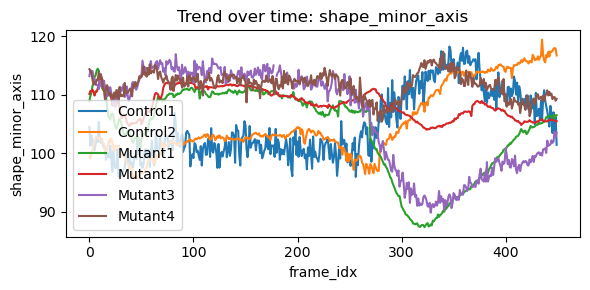

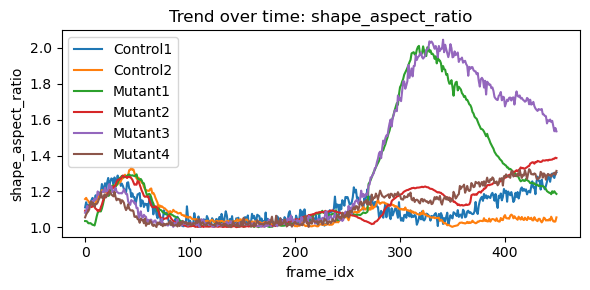

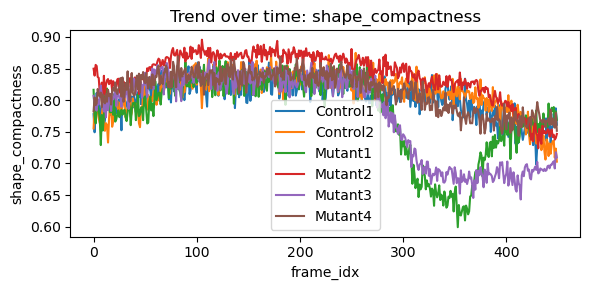

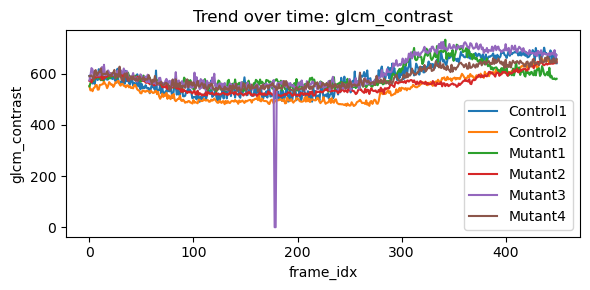

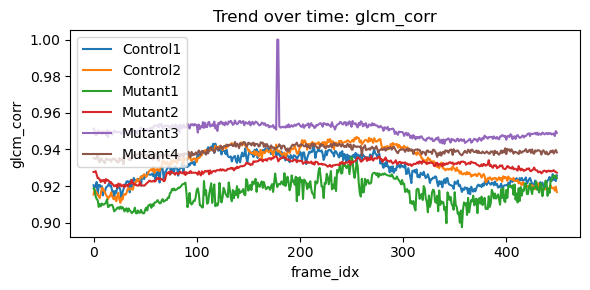

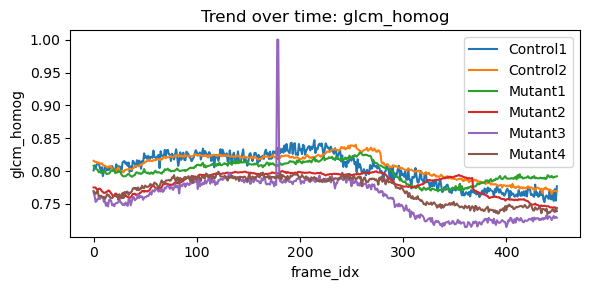

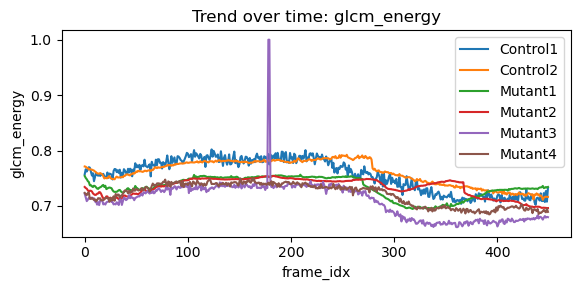

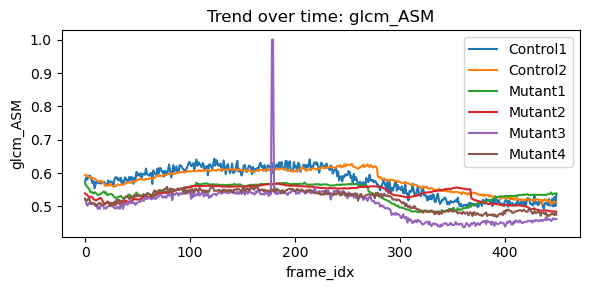

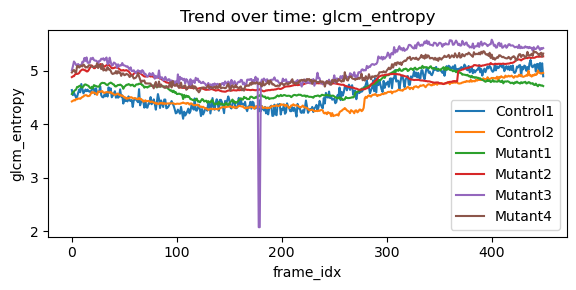

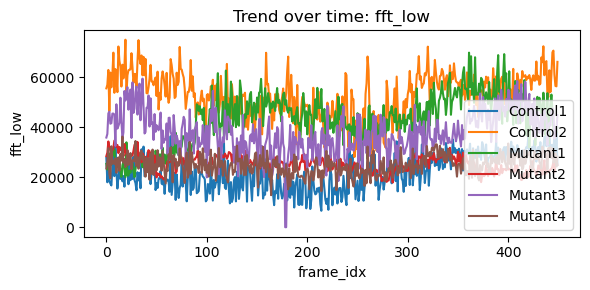

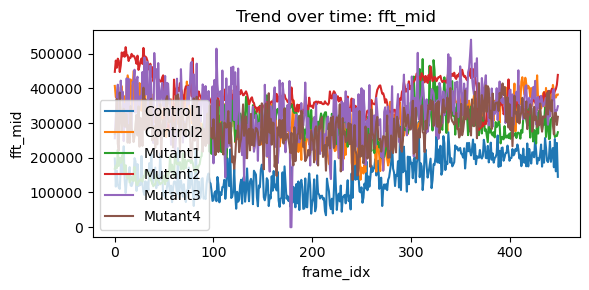

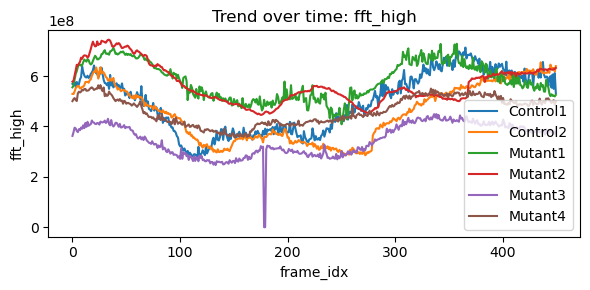

In [17]:
# list of all numeric features
num_features = [c for c in df.columns if c not in ["embryo_id","frame_idx","genotype","group"]]

for feat in num_features:
    plt.figure(figsize=(6,3))
    for lab in df["embryo_id"].unique():
        sub = df[df["embryo_id"]==lab]
        trend = sub.groupby("frame_idx")[feat].mean()
        plt.plot(trend.index, trend.values, label=lab)
    plt.title(f"Trend over time: {feat}")
    plt.xlabel("frame_idx")
    plt.ylabel(feat)
    plt.legend()
    plt.tight_layout()
    plt.show()

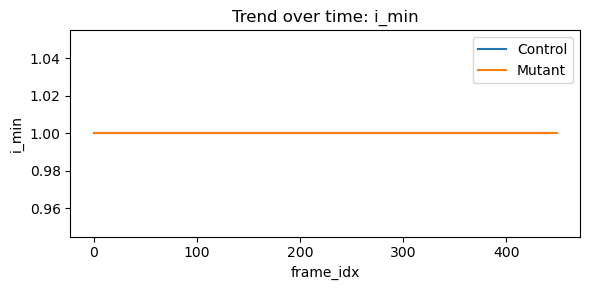

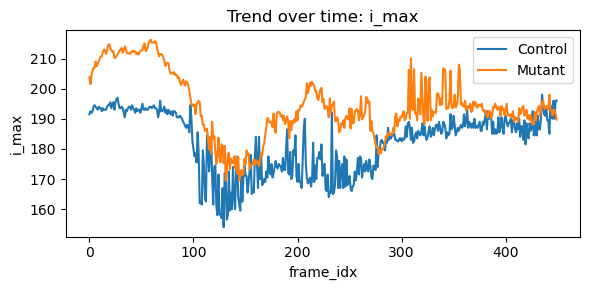

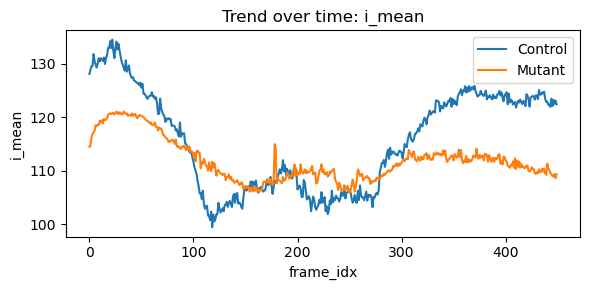

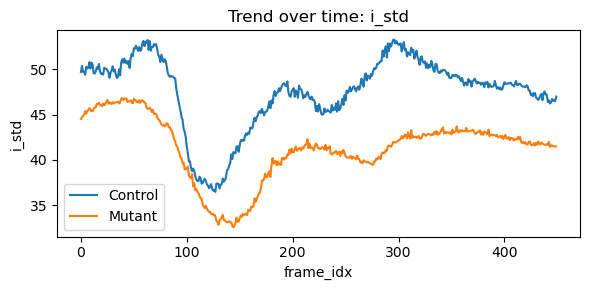

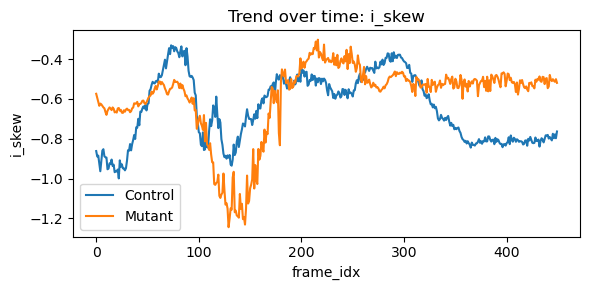

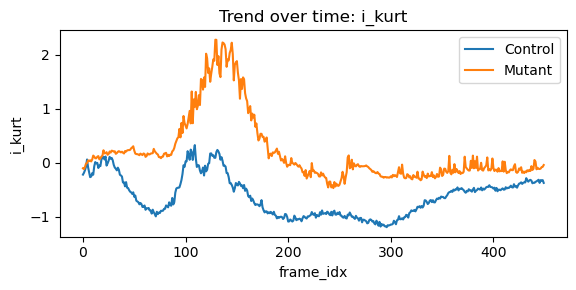

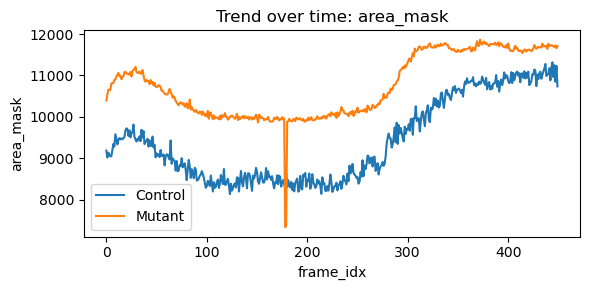

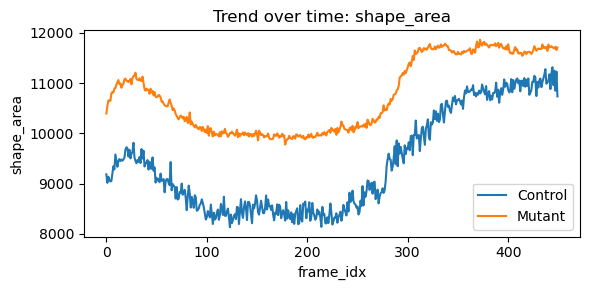

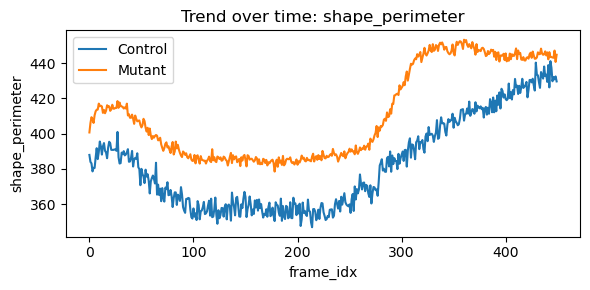

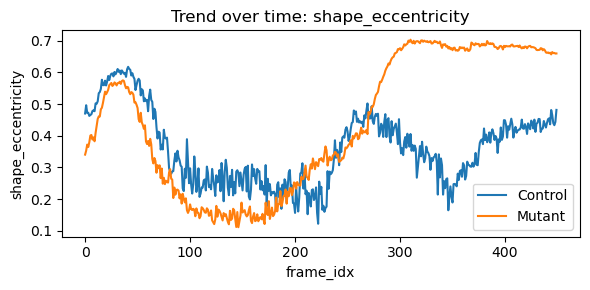

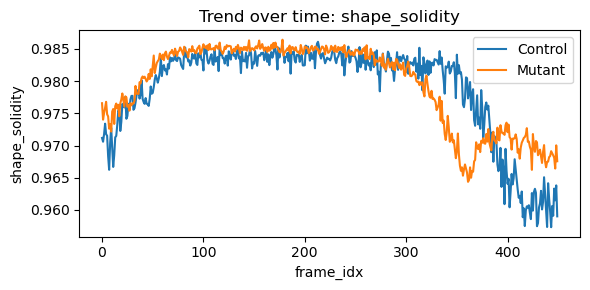

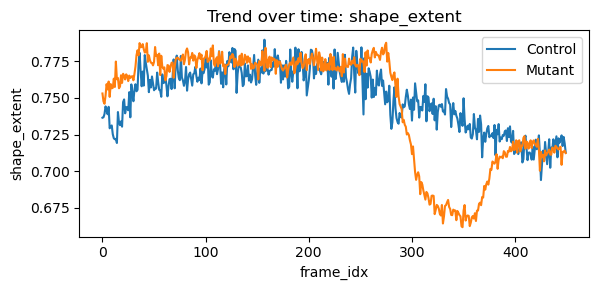

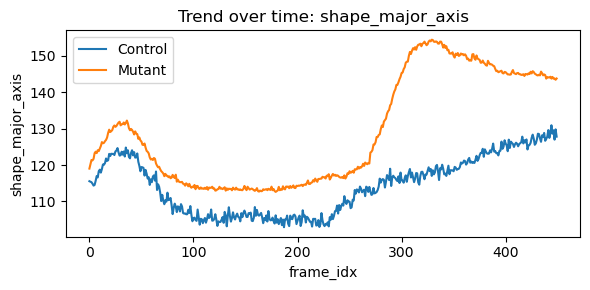

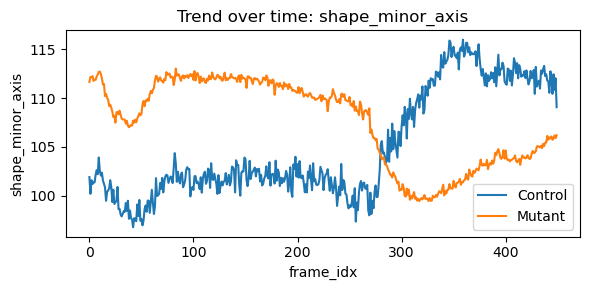

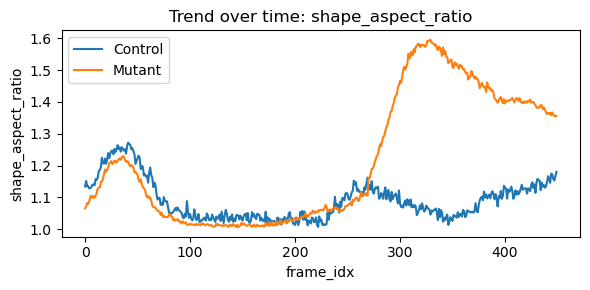

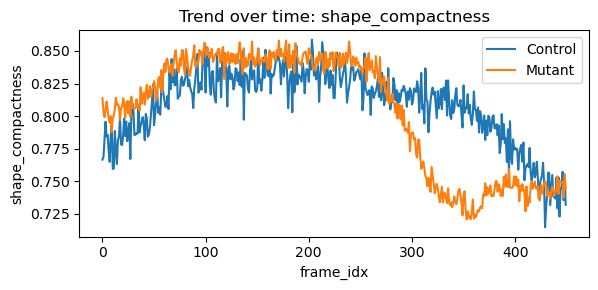

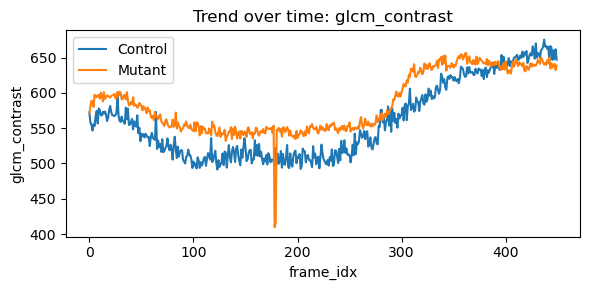

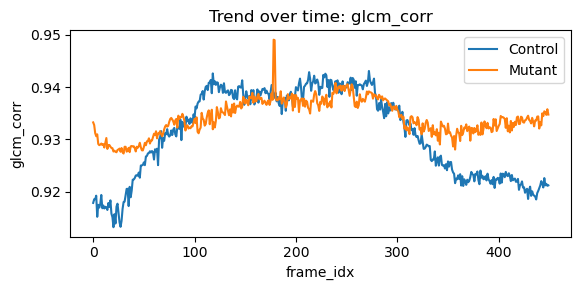

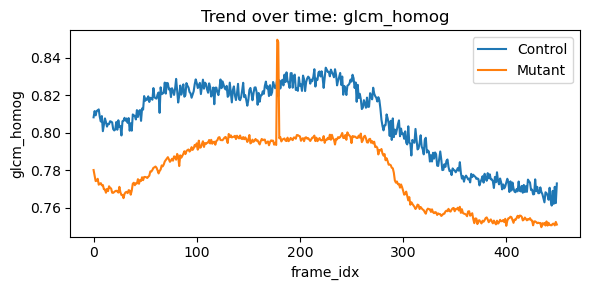

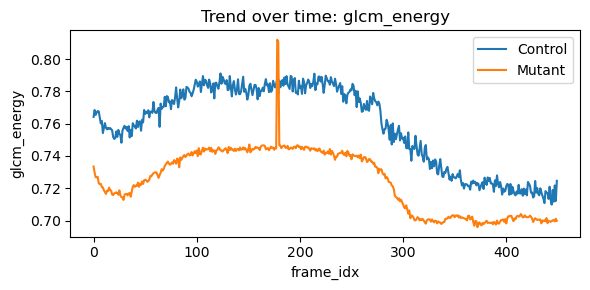

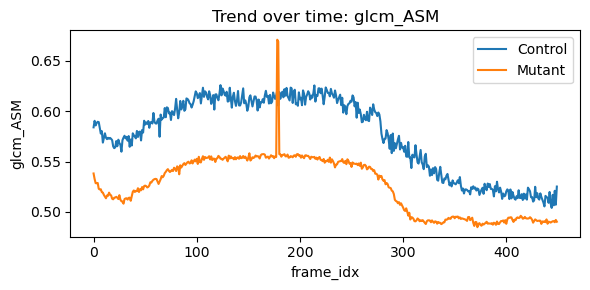

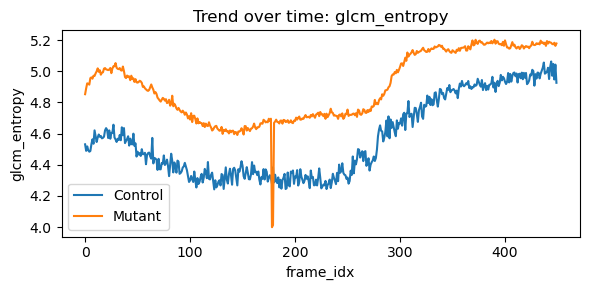

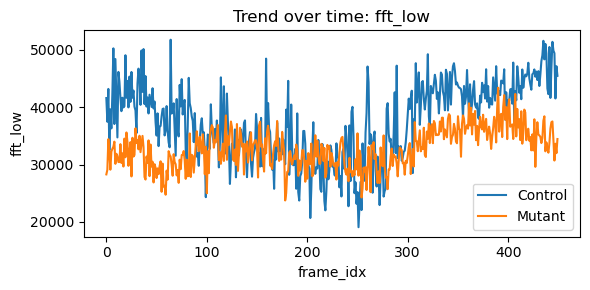

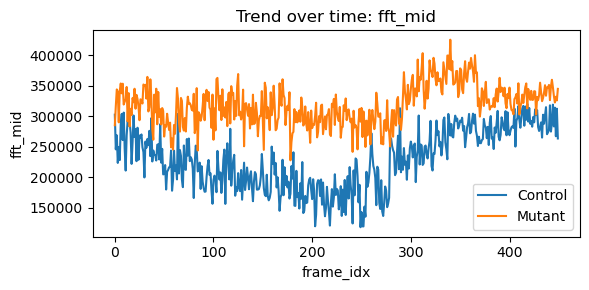

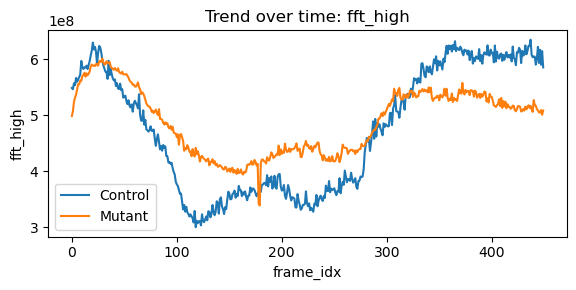

In [18]:
# list of all numeric features
num_features = [c for c in df.columns if c not in ["embryo_id","frame_idx","genotype","group"]]

for feat in num_features:
    plt.figure(figsize=(6,3))
    for lab in df["genotype"].unique():
        sub = df[df["genotype"]==lab]
        trend = sub.groupby("frame_idx")[feat].mean()
        plt.plot(trend.index, trend.values, label=lab)
    plt.title(f"Trend over time: {feat}")
    plt.xlabel("frame_idx")
    plt.ylabel(feat)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [19]:
!pip install torch torchvision torchaudio

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from pathlib import Path
from skimage import io
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

In [ ]:
class DenoisingDataset(Dataset):
    def __init__(self, img_dir, transform=None, noise_std=0.1):
        self.img_paths = sorted(Path(img_dir).glob("*.tif"))  
        self.transform = transform
        self.noise_std = noise_std

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img = io.imread(path).astype(np.float32)   # shape: (H,W) or (S,H,W)

        # Normalize to [0, 1]
        if img.max() > 0:
            img = img / img.max()

        # --- Handle 2D vs 3D stacks ---
        if img.ndim == 2:
            # (H, W) -> (1, H, W)
            img = img[np.newaxis, ...]
        elif img.ndim == 3:
            # (S, H, W) -> mean projection -> (1, H, W)
            img = img.mean(axis=0, keepdims=True)
        else:
            raise ValueError(f"Unexpected image shape {img.shape}")

        # --- Center-crop to a size that is a multiple of 16---
        C, H, W = img.shape
        target_h = (H // 16) * 16   # largest multiple of 16 <= H
        target_w = (W // 16) * 16   # largest multiple of 16 <= W

        top = (H - target_h) // 2
        left = (W - target_w) // 2
        img = img[:, top:top + target_h, left:left + target_w]  # now (1, target_h, target_w)

        # Convert to tensor
        clean = torch.from_numpy(img)

        # Add noise
        noise = torch.randn_like(clean) * self.noise_std
        noisy = clean + noise
        noisy = torch.clamp(noisy, 0., 1.)

        if self.transform is not None:
            noisy = self.transform(noisy)
            clean = self.transform(clean)

        return noisy.float(), clean.float()

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(), 
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

model = DenoisingAutoencoder().to(device)
print(sum(p.numel() for p in model.parameters())/1e6, "M parameters")

In [29]:
IMG_DIR = Path.home() / "Documents/project_004/data/data_small_zfish"

transform = None 

full_dataset = DenoisingDataset(IMG_DIR, transform=transform, noise_std=0.1)
print("Total images:", len(full_dataset))

# Split
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

Total images: 6


noisy: torch.Size([4, 1, 192, 192]) clean: torch.Size([4, 1, 192, 192])


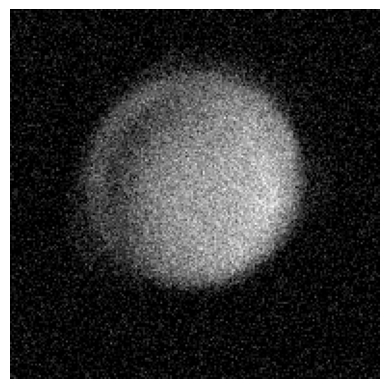

In [45]:
noisy_batch, clean_batch = next(iter(train_loader))
print("noisy:", noisy_batch.shape, "clean:", clean_batch.shape)
plt.imshow(noisy_batch[0,0].cpu(), cmap="gray")
plt.axis("off")
plt.show()

In [46]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    train_loss = 0.0
    for noisy, clean in train_loader:
        noisy = noisy.to(device)
        clean = clean.to(device)

        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * noisy.size(0)

    train_loss /= len(train_loader.dataset)

    # --- validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy = noisy.to(device)
            clean = clean.to(device)
            output = model(noisy)
            loss = criterion(output, clean)
            val_loss += loss.item() * noisy.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")


Epoch 1/20 | train loss: 0.0108 | val loss: 0.0101
Epoch 2/20 | train loss: 0.0127 | val loss: 0.0099
Epoch 3/20 | train loss: 0.0103 | val loss: 0.0100
Epoch 4/20 | train loss: 0.0106 | val loss: 0.0101
Epoch 5/20 | train loss: 0.0098 | val loss: 0.0110
Epoch 6/20 | train loss: 0.0092 | val loss: 0.0114
Epoch 7/20 | train loss: 0.0087 | val loss: 0.0115
Epoch 8/20 | train loss: 0.0084 | val loss: 0.0112
Epoch 9/20 | train loss: 0.0080 | val loss: 0.0110
Epoch 10/20 | train loss: 0.0076 | val loss: 0.0104
Epoch 11/20 | train loss: 0.0073 | val loss: 0.0096
Epoch 12/20 | train loss: 0.0070 | val loss: 0.0085
Epoch 13/20 | train loss: 0.0067 | val loss: 0.0077
Epoch 14/20 | train loss: 0.0065 | val loss: 0.0068
Epoch 15/20 | train loss: 0.0062 | val loss: 0.0064
Epoch 16/20 | train loss: 0.0059 | val loss: 0.0060
Epoch 17/20 | train loss: 0.0057 | val loss: 0.0057
Epoch 18/20 | train loss: 0.0055 | val loss: 0.0053
Epoch 19/20 | train loss: 0.0053 | val loss: 0.0050
Epoch 20/20 | train l

In [54]:
# --- SIMPLE SSIM / PSNR EVAL ---
@torch.no_grad()
def eval_ssim_psnr(model, val_loader, device):
    model.eval()
    ssim_vals, psnr_vals = [], []

    for noisy, clean in val_loader:  # assumes dataset returns (noisy, clean)
        noisy = noisy.to(device)
        clean = clean.to(device)

        pred = model(noisy).clamp(0.0, 1.0)

        # to numpy
        y    = clean.detach().cpu().numpy()
        yhat = pred.detach().cpu().numpy()

        # squeeze channel if present: (B,1,H,W) -> (B,H,W)
        if y.ndim == 4 and y.shape[1] == 1:
            y    = y[:, 0]
            yhat = yhat[:, 0]

        for gt, pr in zip(y, yhat):
            ssim_vals.append(ssim(gt, pr, data_range=1.0))
            psnr_vals.append(psnr(gt, pr, data_range=1.0))

    ssim_mean = float(np.mean(ssim_vals))
    psnr_mean = float(np.mean(psnr_vals))
    print(f"Validation — SSIM: {ssim_mean:.4f} | PSNR: {psnr_mean:.2f} dB")
    return ssim_mean, psnr_mean

# Usage:
ssim_val, psnr_val = eval_ssim_psnr(model, val_loader, device)

Validation — SSIM: 0.2166 | PSNR: 23.27 dB


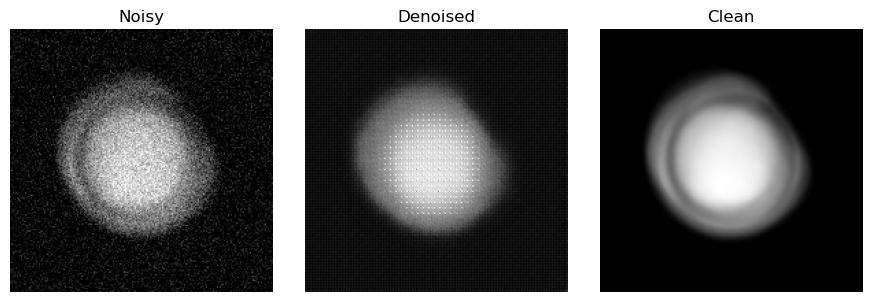

In [49]:
model.eval()
noisy, clean = next(iter(val_loader))
noisy = noisy.to(device)
clean = clean.to(device)

with torch.no_grad():
    out = model(noisy)

noisy_ = noisy[0,0].cpu().numpy()
clean_ = clean[0,0].cpu().numpy()
out_   = out[0,0].cpu().numpy()

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(noisy_, cmap="gray"); plt.title("Noisy");   plt.axis("off")
plt.subplot(1,3,2); plt.imshow(out_,   cmap="gray"); plt.title("Denoised");plt.axis("off")
plt.subplot(1,3,3); plt.imshow(clean_, cmap="gray"); plt.title("Clean");   plt.axis("off")
plt.tight_layout()
plt.show()